Cosumnes Model 
@author: Andrew

In [1]:
# standard python utilities
import os
from os.path import join, exists, dirname, basename
import sys
import glob
from importlib import reload

import pandas as pd
import numpy as np
from scipy.stats import hmean, gmean

# import calendar
import time

# standard python plotting utilities
import matplotlib as mpl
import matplotlib.pyplot as plt

# standard geospatial python utilities
# import pyproj # for converting proj4string
# import shapely
import geopandas as gpd
import rasterio

# mapping utilities
import contextily as ctx
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm



In [2]:
doc_dir = os.getcwd()
while basename(doc_dir) != 'Documents':
    doc_dir = dirname(doc_dir)
# dir of all gwfm data
gwfm_dir = dirname(doc_dir)+'/Box/research_cosumnes/GWFlowModel'
gwfm_dir

'C:\\Users\\ajcalder/Box/research_cosumnes/GWFlowModel'

In [209]:
def add_path(fxn_dir):
    """ Insert fxn directory into first position on path so local functions supercede the global"""
    if fxn_dir not in sys.path:
        sys.path.insert(0, fxn_dir)
# flopy github path - edited
add_path(doc_dir+'/GitHub/flopy')

import flopy 

from importlib import reload
# importlib.reload
# reload(flopy)

# other functions
py_dir = join(doc_dir,'GitHub/CosumnesRiverRecharge/python_utilities')
add_path(py_dir)

from mf_utility import get_layer_from_elev


In [4]:

# ss_bool = True # add steady state period
ss_bool = False # no steady state period

In [5]:

# Transient -> might want to think about making SP1 steady
# calibration run dates
# end_date = pd.to_datetime('2021-09-30')
# strt_date = pd.to_datetime('2018-10-01')

# scenario run_dates dry -> wet -> dry
# end_date = pd.to_datetime('2020-09-30')
# strt_date = pd.to_datetime('2015-10-01')
ss_strt = pd.to_datetime('2010-10-01')
end_date = pd.to_datetime('2020-09-30')
strt_date = pd.to_datetime('2014-10-01')


dates = pd.date_range(strt_date, end_date)

# The number of periods is the number of dates 
nper = len(dates) 
if ss_bool == True:
    nper += 1 

# Each period has a length of one because the timestep is one day, have the 1st stress period be out of the date range
# need to have the transient packages start on the second stress period
perlen = np.ones(nper)
# steady state period can be 1 second
if ss_bool == True:
    perlen[0] = 1/86400  # first period is steady state, rest are transient

# Steady or transient periods
steady = np.zeros(nper)
if ss_bool == True:
    steady[0] = 1  # first period is steady state, rest are transient
steady = steady.astype('bool').tolist()
# Reduce the number of timesteps to decrease run time
# nstp = np.ones(nper)*np.append(np.ones(1),1*np.ones(nper-1))
nstp = np.ones(nper)

In [6]:
# adjusters for boundary condition input
if ss_bool == False:
    time_tr0 = 0  
    nper_tr = nper 
else:
    time_tr0 = 1
    nper_tr = nper-1


In [7]:
nrow=100
ncol=230
delr=200
delc=200
rotation=52.9

# The number of layers should be 1 for the Mehrten formation, 1 for the laguna plus the number of TPROGS layers,
# where the Laguna formation will be clipped by the TPROGS layers
# max_num_layers =148 # based on thickness from -6m (1 m below DEM min) to -80m
# upscale = 8
# nlay_tprogs = int(max_num_layers/upscale)
# tprog_thick = max_num_layers*0.5/nlay_tprogs

# elevation minimum is -1.2 m so have tprogs start at -2 to leave room for filler layer
tprog_strt = -2
# only need tprogs data nearer surface river-aquifer interaction
tprog_total = 64 # 16, 64 3+ hrs #12 
upscale = 8 # from usual 0.5m
tprog_thick = 0.5*upscale
nlay_tprogs = int(tprog_total/tprog_thick)

# nlay_tprogs = 0
# tprog_thick = 0

num_leveling_layers = 1 # layers to create the upscaled unsaturated zone
nlay = 2 + num_leveling_layers + nlay_tprogs

# There is essentially no difference bewtween WGS84 and NAD83 for UTM Zone 10N
# proj4_str='EPSG:26910'
proj4_str='+proj=utm +zone=10 +ellps=WGS84 +datum=WGS84 +units=m +no_defs '
print('TPROGs layers', nlay_tprogs)

TPROGs layers 16


In [8]:
from flopy.utils.geometry import Polygon, LineString, Point
# Original model domain, 44.7 deg angle
# m_domain = gpd.read_file(gwfm_dir+'\\GWModelDomain_UTM10N\\GWModelDomain_Rec_UTM10N.shp')
# New model domain 52.9 deg
m_domain = gpd.read_file(gwfm_dir+'/DIS_data/NewModelDomain/GWModelDomain_52_9deg_UTM10N_WGS84.shp')

# Need to check this when changing model domains
xul, yul = list(m_domain.geometry.values[0].exterior.coords)[1]
list(m_domain.geometry.values[0].exterior.coords)
# m_domain.geometry.values[0].exterior

[(645500.0, 4227700.0),
 (629548.3214234954, 4239764.159754906),
 (657295.8888597784, 4276453.020480867),
 (673247.567436283, 4264388.860725961),
 (645500.0, 4227700.0)]

## Individual Users may change loadpath 
The default loadpath is set to an existing external hard drive for Andrew as F://
If the script doesn't find an external harddrive F:// then it will default to the C:// Drive in WRDAPP

In [9]:
scenario='reconnection'
# scenario='no_reconnection'

In [10]:
ext_dir = 'F:/WRDAPP'
c_dir = 'C:/WRDAPP'

if os.path.exists(ext_dir):
    loadpth = ext_dir 
elif os.path.exists(c_dir):
    loadpth = c_dir 

loadpth = loadpth +'/GWFlowModel/Cosumnes/Regional/'
model_ws = loadpth+'historical_simple_geology'
if scenario=='reconnection':
    model_ws +='_'+scenario

In [11]:
# switch to modflow nwt to enable option bloack for use in owhm
m = flopy.modflow.Modflow(modelname = 'MF', exe_name = 'mf-owhm.exe', 
                          version = 'mfnwt', model_ws=model_ws)
# m = flopy.modflow.Modflow(modelname = 'MF', exe_name = 'mf2005', 
#                           version = 'mf2005', model_ws=model_ws)



In [12]:
os.makedirs(join(model_ws, 'input_data'), exist_ok=True)

In [13]:
# m.model_ws = model_ws

In [14]:
#lenuni = 1 is in ft, lenuni = 2 is in meters
# itmuni is time unit 5 = years, 4=days, 3 =hours, 2=minutes, 1=seconds
dis = flopy.modflow.ModflowDis(nrow=nrow, ncol=ncol, 
                               nlay=nlay, delr=delr, delc=delc,
                               model=m, lenuni = 2, itmuni = 4,
                               xul = xul, yul = yul,rotation=rotation, proj4_str=proj4_str,
                              nper = nper, perlen=perlen, nstp=nstp, steady = steady,
                              start_datetime = strt_date)

In [15]:

# m.modelgrid.set_coord_info(xoff=xll, yoff=yll, proj4='EPSG:32610', angrot=rogation)
mg = m.modelgrid
# Write model grid to shapefile for later use
# mg.write_shapefile(gwfm_dir+'/DIS_data/grid/grid.shp', epsg = '32610')


In [16]:
# Load model grid as geopandas object
grid_p = gpd.read_file(gwfm_dir+'/DIS_data/grid/grid.shp')


In [17]:
grid_elev = gpd.read_file(join(gwfm_dir,'DIS_data','grid_elevation_m_statistics.shp'))

In [18]:
# get exterior polyline of model grid
grid_bnd = gpd.GeoDataFrame(pd.DataFrame([0]), geometry = [grid_p.unary_union.exterior], crs=grid_p.crs)
# find cells that construct the model boundary
bnd_cells_df = gpd.sjoin(grid_p, grid_bnd)
bnd_cells = bnd_cells_df[['row','column']] - 1
bnd_cells['grid_id'] = np.arange(0,len(bnd_cells))
bnd_rows, bnd_cols = bnd_cells.row.values, bnd_cells.column.values

In [19]:
# Based on Maribeth's grid aligned with Alisha's TPROGS model
# dem_data = np.loadtxt(gwfm_dir+'\DIS_data\dem_52_9_200m_nearest.tsv', delimiter = '\t')
# dem_data = np.loadtxt(gwfm_dir+'\DIS_data\dem_52_9_200m_linear.tsv', delimiter = '\t')
dem_data = np.loadtxt(gwfm_dir+'/DIS_data/dem_52_9_200m_mean.tsv')

# import seaborn as sns
# sns.heatmap(dem_data, cmap = 'viridis', vmin = 0,square=True)

# Load aquifer formation bottoms
- Laguna bottom (Mehrten top)  
- Mehrten bottom after adjustment to account for laguna bottom
- no flow boundary is the original mehrten bottom

In [20]:
botm = np.zeros(m.dis.botm.shape)
bas_dir = join(gwfm_dir, 'BAS6')
botm[-2] = np.loadtxt(join(bas_dir, 'mehrten_top.txt'))
botm[-1] = np.loadtxt(join(bas_dir, 'mehrten_bottom.txt'))
no_flow_bound = np.loadtxt(join(bas_dir, 'no_flow_boundary.txt'))

## Adjustment to bottom boundary to ensure sufficient top layer thickness for the TPROGS model
Although the bottom boundaries are being artifically lowered to allow for sufficient layer thickness, this will be corrected when ibound is implemented based on where the actual bottom boundary is and where there is high elevations based on likelihood to be volcanics geology.  
TPROGs extends from -80 to 80. The lowest point in the DEM is -5m, we should drop more than 1m below this to ensure adequate thickness for calculations. This leaves -6 m to -80 for TPROGs with standard upscaling, so 148 layers

In [21]:
# The TPROGS model is 100m thick with some of it above the land surface
# to be safe, there should be at least 50 meters below ground surface to the bottom boundary

# Create 4 layers representing the upscaled "unsaturated" zone 
# ensures there is at least 1 m for each upscaled layer and rounded to create a clean boundary with the TPROGS data
# leveling_layer_bottom = np.round(np.min(dem_data) - num_leveling_layers*1) - 1
# minimum thickness between top layer and Laguna?
leveling_layer_thickness = -10 # (dem_data - leveling_layer_bottom)/num_leveling_layers
botm[num_leveling_layers-1,:,:] = tprog_strt
for i in np.arange(num_leveling_layers-1,0,-1):
    botm[i-1,:,:] = botm[i,:,:] + leveling_layer_thickness
    
# Create TPROGS layers from top down
for i in np.arange(num_leveling_layers, num_leveling_layers + nlay_tprogs):
    botm[i,:,:] = botm[i-1,:,:] -tprog_thick
    
# Thickness to give to bottom layers below the TPROGS layers just to provide adequate spacing,
# this will be corrected by changing the geology in the layers above to account for what is actually in
# the Mehrten and what is in the Laguna formations, thickness of 5 also prevents any messy overlap
thickness_to_skip =10
# # Find where top boundary of Mehrten Formation rises within 10 meters of the top layer (10m for sufficient layer thickness)
bot3ind = np.min(np.where(botm[-2,:,:]>botm[-3,:,:]- thickness_to_skip)[1])

# # Where the top boundary of Mehrten was within 10 meters of the top layer 
# # set it equal to top layer elevation minus 10 for sufficient layer thickness
botm[-2,:,bot3ind:] = botm[-3,0,bot3ind]- thickness_to_skip
# # Repeat steps above for bottom of Mehrten formation with the top of the Mehrten formation
bot3ind = np.min(np.where(botm[-1,0,:]>botm[-2,0,:]- thickness_to_skip))
botm[-1,:,bot3ind:] = botm[-2,0,bot3ind]-thickness_to_skip

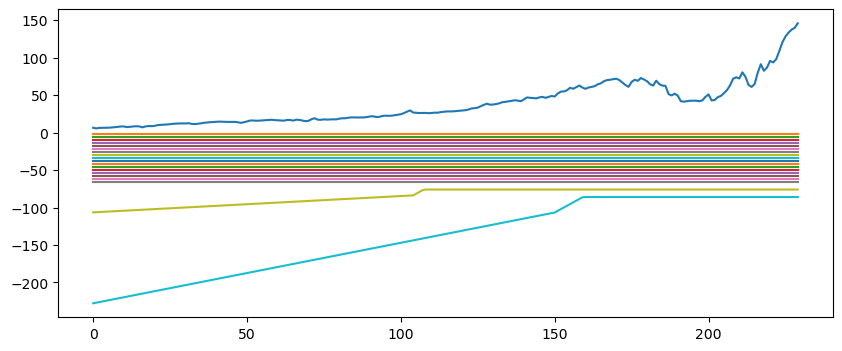

In [22]:
# when you apply the 1/200 aspect the dips in the cell seem a lot less severe, so may just leave the layering as is
# for now with 4 layers representing the unsaturated zone
fig,ax = plt.subplots(figsize = (10,4))
# ax.set_aspect(aspect = 1/10)
plotrow = 80
plt.plot(dem_data[plotrow,:])

for i in np.arange(0,nlay):
    plt.plot(botm[i,plotrow,:])

In [23]:
# Set the elevation of the top layer based on the DEM
m.dis.top = dem_data
# Bottom of model based on geology
m.dis.botm = botm
chk = dis.check()
chk.summary_array

# join top and botm for easier array referencing for elevations
top_botm = np.zeros((m.dis.nlay+1,m.dis.nrow,m.dis.ncol))
top_botm[0,:,:] = m.dis.top.array
top_botm[1:,:,:] = m.dis.botm.array




DIS PACKAGE DATA VALIDATION:
  5 Errors:
    5 instances of thin cells (less than checker threshold of 1.0)

  Checks that passed:
    zero or negative thickness
    nan values in top array
    nan values in bottom array



In [24]:
# dis.write_file()

## Complex ibound

### Define no flow cells based on elevation, informed by DWR cross sections and geologic maps of volcanic geology fingers leaving the mountains
In general, the location of Michigan Bar is near the boundary where there is total volcanics to majority alluvium. However there is a major finger North and South of the Cosumnes River of andesititc conglomerate, sandstone, breccia

In [25]:
# slope doesn't provide clear guidance on differentiating foothills
# slope_gdf = gpd.read_file(join(gwfm_dir, 'DIS_data', 'grid_zonal_stats','slope_percentage_statistics.shp'))

# slope = np.zeros((nrow,ncol))
# slope[slope_gdf.row-1, slope_gdf.column-1] = slope_gdf['mean']

# plt.imshow(slope>3)

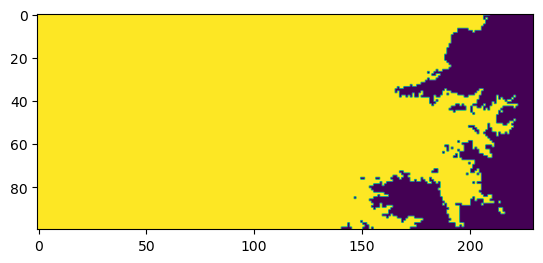

In [26]:
# Simplified ibound, only no flow cell if it is below the bottom of the Mehrten Formation
# Specify no flow boundary based on rough approx of geology (upper basin volcanics)
ibound = np.ones([nlay, nrow,ncol])


cutoff_elev = 56
ibound = ibound*(dem_data<cutoff_elev)

plt.imshow(ibound[0,:,:])

### Create a line bounding the noflow region to set the specified head boundary

In [27]:
import pprint
from rasterio.features import shapes, rasterize

# The function shapes from rasterio requires uint8 format
ibound_line = ibound.astype(rasterio.uint8)
out = shapes(ibound_line,connectivity = 8)
alldata = list(out)

# maxl = 0
maxl = np.zeros(len(alldata))
for i in np.arange(0,len(alldata)):
    maxl[i] = len(alldata[i][0].get('coordinates')[0])
#     if len(alldata[i][0].get('coordinates')[0])>maxl:
#         maxl = len(alldata[i][0].get('coordinates')[0])
#         ind = i
# select the two longest linestring indexes (1st will be chunk down of divide (lower elevation) 2nd will chunk above (high elev))
maxl1, maxl2 = np.where(maxl>np.mean(maxl))[0]
print(maxl[maxl>np.mean(maxl)])

[533. 495.]


In [28]:
temp = alldata[maxl2][0].get('coordinates')[0]
tl = LineString(temp)
tl

In [29]:
from shapely.ops import LineString, linemerge, polygonize, unary_union
tl = LineString(temp)

# Get the constant head or general head boundary after the no flow cells
linerast = rasterio.features.rasterize([tl], out_shape = np.array((nrow,ncol)))
# remove far east bound line
linerast[:,ncol-1] = 0
fix_bound = np.min(np.argwhere(linerast[0,:]==1))
linerast[0,:] = 0
linerast[0,fix_bound]
np.shape(linerast)

# ibound[0,linerast==1] = -1

(100, 230)

In [30]:
from shapely.ops import LineString, linemerge, polygonize, unary_union
tl = LineString(temp)
tu = unary_union(tl)
poly = list(polygonize(tu))
# Set the polygon/raster for the top layer, no buffer needed
poly0 = poly[0].buffer(distance = 0)
polyrast0 = rasterio.features.rasterize([poly0], out_shape = np.array((nrow,ncol)))
# Set the polygon/raster for the top layer, slight buffer needed to expand geologic formation outward with depth as 
# naturally occurs
poly1 = poly[0].buffer(distance = 13)
polyrast1 = rasterio.features.rasterize([poly1], out_shape = np.array((nrow,ncol)))
# Set the polygon/raster for the bottom layer, largest buffer needed
poly2 = poly[0].buffer(distance = 17)
polyrast2 = rasterio.features.rasterize([poly2], out_shape = np.array((nrow,ncol)))

ibound = np.ones([nlay, nrow,ncol])
# Need to decide whether all layers or just the top layer are affected by ibound from elevation
# it is better to define the top layer with a simple dem>elevation check than the rasterize functins that isn't perfect
# ibound[0,polyrast0==1] = 0
# Need to decide whether all layers or just the top layer are affected by ibound from elevation
ibound[-2,polyrast1==1] = 0
# Need to decide whether all layers or just the top layer are affected by ibound from elevation
ibound[-1,polyrast2==1] = 0

# The bottom boundary has a dip of 1-2 degrees which is essentially a slope of 0.015 based on given cross section data
# The layer thickness for TPROGS
laythk = tprog_thick
# It appeared shapely buffer is on the scale of kilometers
run = (laythk/0.015)/1000
run_const = run
for i in np.arange(1,nlay-2):
    # error saying poly[i] is not subscriptable
    polyi = poly[0].buffer(distance = run)
    polyrast = rasterio.features.rasterize([polyi], out_shape = np.array((nrow,ncol)))
    # Need to decide whether all layers or just the top layer are affected by ibound from elevation
    ibound[i,polyrast==1] = 0
    run += run_const

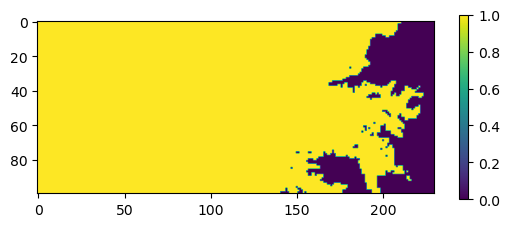

In [31]:
# wherever the constant head/specified head bound is the cells need to be active
ibound[0,dem_data>cutoff_elev] = 0
ibound[0,linerast==1] = 1
plt.imshow(ibound[0,:,:])
plt.colorbar(shrink=0.5)

In [32]:
# copy the ibound array to alter the geology array to set these cells as low permeability formations
# either marine or volcanic based
deep_geology = np.invert(ibound[:,:,:].astype(bool))

# reset ibound to all active cells to reduce non-linearity
# still need to take account of no flow cells for lake package
ibound = np.ones([nlay, nrow,ncol])

In [33]:
np.savetxt(gwfm_dir+'/BAS6/deep_geology_'+str(nlay)+'layer.tsv', np.reshape(deep_geology, (nlay*nrow,ncol)), delimiter ='\t')
np.savetxt(model_ws+'/input_data/deep_geology.tsv', np.reshape(deep_geology, (nlay*nrow,ncol)), delimiter ='\t')
# deep_geology = np.loadtxt(m.model_ws+'/input_data/deep_geology.tsv', delimiter ='\t')
# deep_geology = np.reshape(deep_geology, (nlay,nrow,ncol))

### Remove no flow cells in the first layer where there are stream cells

In [34]:
# where the specified head boundary is the cells must be active
# ibound[0,chd_locs[0], chd_locs[1]] = -1

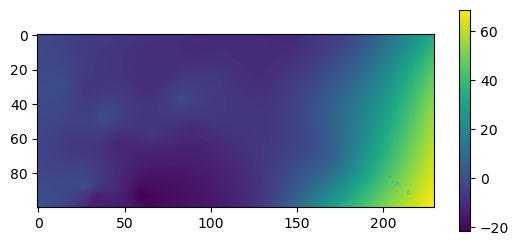

In [35]:
# update steady state to be a best available head contours map
ghb_dir = gwfm_dir+'/GHB_data'

year = strt_date.year # 2016
filename = glob.glob(ghb_dir+'/final_WSEL_arrays/spring'+str(year)+'_kriged_WSEL.tsv')[0]
# convert from ft to meters
hd_strt = np.loadtxt(filename)*0.3048
# where head is  above land surface set to 15 ft below land surface
hd_strt[hd_strt > m.dis.top.array] = m.dis.top.array[hd_strt > m.dis.top.array] - 15*0.3048

dtw_strt = m.dis.top.array - hd_strt
plt.imshow(hd_strt)
plt.colorbar(shrink=0.6)

In [36]:
strt = np.ones((nlay, nrow, ncol), dtype = np.float32)
# The model should start in hydraulic connection
if ss_bool == True:
    strt[:,:,:] = m.dis.top[:,:] #maybe the mean of starting heads i causing issues?

#start with adjusted head contours because the steady state is causing the model to start off
if ss_bool == False:
    strt[:,:,:] = hd_strt

In [37]:
# Basic package, BAS

# ibound < 0 is constant head
# ibound = 0 is inactive cell
# ibound > 0 is active cell
# strt is array of starting heads
# add option: STOPERROR 0.01 to reduce percent error when OWHM stops model
# if solver criteria are not met, the model will continue if model percent error is less than stoperror
bas = flopy.modflow.ModflowBas(model = m, ibound=ibound, strt = strt) #, stoper = 1)

In [38]:
# may have to manually add since it seems to overwrite
# allows model to continue even if convergence fails
# bas.options = bas.options +' NO_FAILED_CONVERGENCE_STOP'
# # saves a simple volumetric budget outside of list file
# bas.options = bas.options + 'BUDGETDB flow_budget.txt'


In [39]:
bas.check()
# bas.write_file()


BAS6 PACKAGE DATA VALIDATION:
  No errors or warnings encountered.

  Checks that passed:
    isolated cells in ibound array
    Not a number



## Northwest and Southeast GHB boundaries based on historical WSEL
**Units are in feet** 

In [40]:
# def get_layer_from_elev(elev, botm_slice, nlay):
#     """  Return uppermost model layer (0-based) occupied at least partly by some elevation data
#     Parameters
#     ----------
#     elev: 1D array (n) with elevations matching model elevation units
#     botm: 2D array (nlay, n) with layer elevations of model using same x,y locations at elev1D
#     """
#     elev_lay = np.zeros(len(elev))
#     for k in np.arange(0,nlay-1):
#         for j in np.arange(0,len(elev)):
#             if botm_slice[k,j] > elev[j]:
#                 elev_lay[j] = k + 1
#     return(elev_lay.astype(int))
                


In [41]:
# raster cropping will be done in outside script so the only part read in will be the final array
ghb_dir = gwfm_dir+'/GHB_data'

In [42]:
strtyear = strt_date.year
endyear = end_date.year+1
kriged_fall = np.zeros((int(endyear-strtyear),nrow,ncol))
kriged_spring = np.zeros((int(endyear-strtyear),nrow,ncol))

# keep track of which place in array matches to year
year_to_int = np.zeros((endyear-strtyear,2))

for t, year in enumerate(np.arange(strtyear,endyear)):
    # load and place spring kriged data in np array, load spring first
    filename = glob.glob(ghb_dir+'/final_WSEL_arrays/spring'+str(year)+'_kriged_WSEL.tsv')[0]
    # convert from feet to meters
    kriged_spring[t,:,:] = np.loadtxt(filename)*0.3048
    # load and place fall kriged data in np array
    filename = glob.glob(ghb_dir+'/final_WSEL_arrays/fall'+str(year)+'_kriged_WSEL.tsv')[0]
    # convert from feet to meters
    kriged_fall[t,:,:] = np.loadtxt(filename)*0.3048

    year_to_int[t,0] = t
    year_to_int[t,1] = year
    

In [43]:
# ceate multi, index to stack fall and spring data
sy_ind = np.repeat(['Apr','Oct'],(endyear-strtyear)),np.tile(np.arange(strtyear,endyear),2)
sy_ind = pd.MultiIndex.from_arrays(sy_ind, names=['month','year'])


In [44]:
# stack fall and spring before resampling
kriged_arr = np.vstack((kriged_spring, kriged_fall))

# Set kriged water table elevations that are above land surface to land surface minus 15 ft (based on historical levels)
# in floodplain elevations can come up to ground surface
# dem_offset = 15*0.3048
dem_offset = 0
kriged_arr = np.where(kriged_arr>dem_data, dem_data- dem_offset, kriged_arr)

kriged = kriged_arr[:, bnd_rows, bnd_cols]


C:\Users\ajcalder\Anaconda3\envs\geo_env\lib\site-packages\pandas\plotting\_matplotlib\core.py:792: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  handles = leg.legendHandles
C:\Users\ajcalder\Anaconda3\envs\geo_env\lib\site-packages\pandas\plotting\_matplotlib\core.py:792: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  handles = leg.legendHandles


<Axes: >

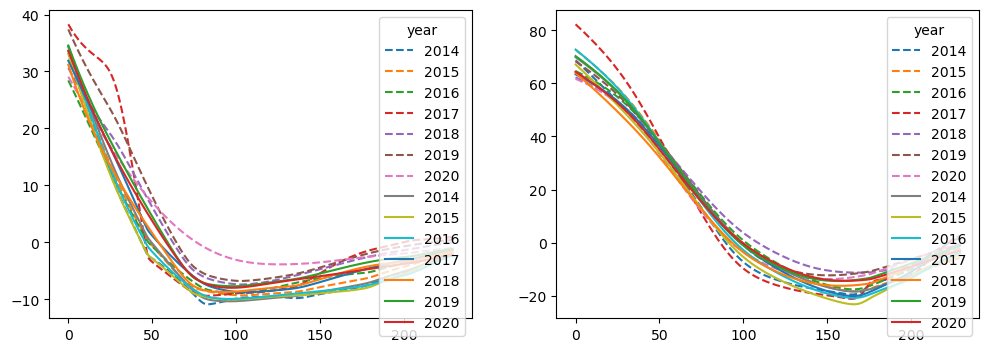

In [45]:
## NW is row 0, SE is last row
kriged_NW = np.vstack((kriged_spring[:,0,:],kriged_fall[:,0,:]))
kriged_SE = np.vstack((kriged_spring[:,nrow-1,:],kriged_fall[:,nrow-1,:] ))
fig,ax=plt.subplots(1,2, figsize=(12,4))
pd.DataFrame(np.rot90(kriged_NW),columns=sy_ind).loc[:,'Apr'].plot(ax=ax[0],linestyle='--')
pd.DataFrame(np.rot90(kriged_NW),columns=sy_ind).loc[:,'Oct'].plot(ax=ax[0])

pd.DataFrame(np.rot90(kriged_SE),columns=sy_ind).loc[:,'Apr'].plot(ax=ax[1],linestyle='--')
pd.DataFrame(np.rot90(kriged_SE),columns=sy_ind).loc[:,'Oct'].plot(ax=ax[1])

## Read in TPROGS data

In [46]:
gel_dir = join(gwfm_dir,'UPW_data')


In [47]:
eff_K = pd.read_csv(join(gel_dir, 'permeameter_regional.csv'))

In [381]:
def param_check(model_ws, file_dir, file_name):
    """ Check if a file exists in the model directory if not copy from Box location"""
    if file_name in os.listdir(model_ws):
        print('exists')
        params = pd.read_csv(join(model_ws, file_name))
    else:
        params = pd.read_csv(join(gel_dir,file_name))
        params.to_csv(join(model_ws,file_name), index=False)
    return(params)


In [407]:
mf_tprogs_dir = gwfm_dir+'/UPW_data/tprogs_final/'
tprogs_files = glob.glob(mf_tprogs_dir+'*')

params = param_check(model_ws, gel_dir, 'ZonePropertiesInitial.csv')  
params = params.set_index('Zone')
# convert from m/s to m/d
params['K_m_d'] = params.K_m_s * 86400    

exists


In [445]:
bc_params = pd.read_csv(join(model_ws,'BC_scaling.csv'))
bc_params = bc_params.set_index('ParamName')

In [49]:
tprogs_fxn_dir = doc_dir+'/GitHub/CosumnesRiverRecharge/tprogs_utilities'
if tprogs_fxn_dir not in sys.path:
    sys.path.append(tprogs_fxn_dir)
# sys.path
import tprogs_cleaning as tc

# reload(tc)

Realization 89 was used for model development because tprogs analysis at one point found realization 89 had the mean conductivity in the area of Blodgett Dam.  
A parallel run of 100 realizations found r043 had the best NSE, after updating the model with EVT for GDEs and other updates it might be necessary to double check.

In [50]:

t=43
tprogs_info = [80, -80, 320]

tprogs_line = np.loadtxt(tprogs_files[t])
masked_tprogs= tc.tprogs_cut_elev(tprogs_line, dem_data, tprogs_info)
K, Sy, Ss, porosity = tc.int_to_param(masked_tprogs, params, porosity=True)

# save tprogs facies array as input data for use during calibration
tprogs_dim = masked_tprogs.shape
np.savetxt(model_ws+'/input_data/tprogs_facies_array.tsv', np.reshape(masked_tprogs, (tprogs_dim[0]*nrow,ncol)), delimiter='\t')
# masked_tprogs = np.reshape(np.loadtxt(model_ws+'/input_data/tprogs_facies_array.tsv', delimiter='\t'), (320,100,230))


In [51]:
# error checking
# model_ws0= loadpth+'historical_simple_geology'
# masked_tprogs0 = np.reshape(np.loadtxt(model_ws0+'/input_data/tprogs_facies_array.tsv', delimiter='\t'), (320,100,230))
# masked_tprogs-masked_tprogs0

## LPF/UPW package

In [52]:
hk = np.zeros(botm.shape)
vka = np.zeros(botm.shape)
sy = np.zeros(botm.shape)
ss = np.zeros(botm.shape)

In [53]:
top = np.copy(botm[0,:,:]) # bottom of levelling layer
bot1 = np.copy(botm[-3,:,:]) # top of laguna

# I need to verify if a flattening layer is needed (e.g., variable thickness to maintain TPROGs connectivity)
# pull out the TPROGS data for the corresponding depths
K_c = tc.get_tprogs_for_elev(K, top, bot1, tprogs_info)
Ss_c = tc.get_tprogs_for_elev(Ss, top, bot1, tprogs_info)
Sy_c = tc.get_tprogs_for_elev(Sy, top, bot1, tprogs_info)
n_c = tc.get_tprogs_for_elev(porosity, top, bot1, tprogs_info)

# upscale as preset
for kt, k in enumerate(np.arange(1,nlay_tprogs+1)):
    hk[k,:] = np.mean(K_c[upscale*kt:upscale*(kt+1)], axis=0)
    vka[k,:] = hmean(K_c[upscale*kt:upscale*(kt+1)], axis=0)
    ss[k,:] = np.mean(Ss_c[upscale*kt:upscale*(kt+1)], axis=0)
    sy[k,:] = np.mean(Sy_c[upscale*kt:upscale*(kt+1)], axis=0)
#     por[k,:] = np.mean(n_c[upscale*kt:upscale*(kt+1)], axis=0)

In [54]:
top = m.dis.top.array
bot1 = m.dis.botm.array[0,:,:]
# set parameters based on upscaled unsaturated zone
hk[0,:,:] = np.mean(tc.get_tprogs_for_elev(K, top, bot1,tprogs_info),axis=0)
vka[0,:,:] = hmean(tc.get_tprogs_for_elev(K, top, bot1,tprogs_info),axis=0)
sy[0,:,:] = np.mean(tc.get_tprogs_for_elev(Sy, top, bot1,tprogs_info),axis=0)
ss[0,:,:] = np.mean(tc.get_tprogs_for_elev(Ss, top, bot1,tprogs_info),axis=0)



In [55]:
rows,cols = grid_p.row.values-1, grid_p.column.values-1

In [56]:
# check proportions of hydrofacies in TPROGs realization
tprogs_vals = np.arange(1,5)
tprogs_hist = np.histogram(masked_tprogs, np.append([0],tprogs_vals+0.1))[0]
tprogs_hist = tprogs_hist/np.sum(tprogs_hist)

tprogs_quants = 1 - np.append([0], np.cumsum(tprogs_hist)/np.sum(tprogs_hist))
vka_quants = pd.DataFrame(tprogs_quants[1:], columns=['quant'], index=tprogs_vals)
# dataframe summarizing dominant facies based on quantiles
vka_quants['vka_min'] = np.quantile(vka, tprogs_quants[1:])
vka_quants['vka_max'] = np.quantile(vka, tprogs_quants[:-1])
vka_quants['facies'] = params.loc[tprogs_vals].Lithology.values
# scale vertical conductivity with a vertical anisotropy factor based
# on quantiles in the upscaled tprogs data
for p in tprogs_vals:
    vka[(vka<vka_quants.loc[p,'vka_max'])&(vka>vka_quants.loc[p,'vka_min'])] /= params.vani[p]


The tuff breccia is very dense, hard and low water yielding. It is supposedly responsible for the many "haystack" hills in the eastern part of the county

DWR report has a few final well pumping rates, drawdowns and specific capacities but limited.

Fleckenstein et al. 2006 found the Mehrten had  
Kh = 1 to 1.8 x10^-5 m/s  
Kv = 1 to 1.8 x10^-7 m/s  
vani ~= 100  
Sy = 0.15 to 0.2  
Ss = 1e-4 to 1e-3 m^-1  

In [57]:
# set values for second to bottom layer, Laguna formation
hk[-2,:,:] = params.loc[5,'K_m_d']
vka[-2,:,:] = params.loc[5,'K_m_d']/params.loc[5,'vani'] 
sy[-2,:,:] = params.loc[5,'Sy']
ss[-2,:,:] = params.loc[5,'Ss']

# this is causing potentially high water levels in the foothills
# the deep_geology array shows where the mehrten formation comes out of the surface
# hk[deep_geology[:,:,:].astype(bool)] = params.loc[7,'K_m_d']
# vka[deep_geology[:,:,:].astype(bool)] = params.loc[7,'K_m_d']/params.loc[7,'vani'] 
# sy[deep_geology[:,:,:].astype(bool)] = params.loc[7,'Sy']
# ss[deep_geology[:,:,:].astype(bool)] = params.loc[7,'Ss']

# set values for bottom layer, Mehrten formation
hk[-1,:,:] = params.loc[6,'K_m_d']
vka[-1,:,:] = params.loc[6,'K_m_d']/params.loc[6,'vani'] 
sy[-1,:,:] = params.loc[6,'Sy']
ss[-1,:,:] = params.loc[6,'Ss']

In [58]:
# rather than use a variable deep geology array which is complicated to determine local effects
# use the mean column for each layer to define a block of Low K to correct gradient in the foothill
adj_lowK = pd.DataFrame(np.transpose(np.where(deep_geology>0)), columns=['k','i','j'])
# the mean didn't quite extend far enough or wasn't low enough K
# adj_lowK = adj_lowK.groupby('k').mean()['j'].astype(int)
# trying near minimum to extend further, manually adjusted to 0.15 by comparing to dem_data>56
adj_lowK = adj_lowK.groupby('k').quantile(0.15)['j'].astype(int)
adj_lowK_arr = np.zeros((nlay,nrow,ncol))
for k in adj_lowK.index:
    adj_lowK_arr[k, :, adj_lowK.loc[k]:] = 1
# don't want to adjust deepest two layers?
# this doesn't make as much sense geologically
# adj_lowK_arr[-1] = 0
# adj_lowK_arr[-2:] = 0
# this is causing potentially high water levels in the foothills
# the deep_geology array shows where the mehrten formation comes out of the surface
hk[adj_lowK_arr.astype(bool)] = params.loc[7,'K_m_d']
vka[adj_lowK_arr.astype(bool)] = params.loc[7,'K_m_d']/params.loc[7,'vani']
sy[adj_lowK_arr.astype(bool)] = params.loc[7,'Sy']
ss[adj_lowK_arr.astype(bool)] = params.loc[7,'Ss']

In [59]:
# fig,ax =plt.subplots(3,1)
# ax[0].imshow(adj_lowK_arr[:,0], aspect=10)
# ax[1].imshow(adj_lowK_arr[0,:])
# ax[2].imshow(deep_geology[0])

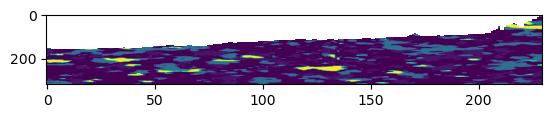

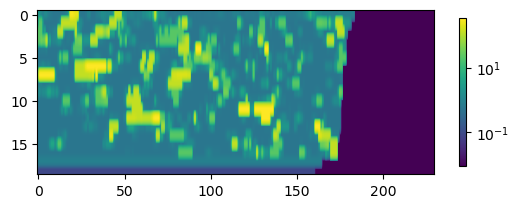

In [60]:
# plt.imshow(K[0,:,:])
# plt.imshow(K[-1,:,:])
row = 50
plt.imshow(K[:,row,:],aspect=1/10)
plt.show()
plt.imshow(vka[:,row,:],aspect=5, norm=mpl.colors.LogNorm())
plt.colorbar(shrink=0.4)
plt.show()

In [394]:
# this may not be needed
# reduce sand/gravel vka for seepage in LAK/SFR assuming some fining
seep_vka = np.copy(vka)
coarse_cutoff = vka_quants.loc[2,'vka_min'] # sand minimum
seep_vka[seep_vka > coarse_cutoff] /= bc_params.loc['coarse_scale', 'StartValue']
print('coarse cutoff %.1f' %coarse_cutoff)
print('coarse fraction adjusted is %.2f %%' %((seep_vka>coarse_cutoff).sum()*100/(seep_vka>0).sum()))

# model review has shown that stream leakage is the cause of excess heads in the foothills
# the solution is to scale strhc1 in the foothills by 1/10 or more (over the deep geology generally)
# seep_vka[adj_lowK_arr[:-2].astype(bool)] /= 10
# column 150 is just below roooney, where east wells oversimulate
# seep_vka /= 4 # divide everything by 2
# seep_vka[:,:,120:] /= 15

# apply additional scaling factors by breaking columns into 5 groups
stp = int(ncol/5)
for n in np.arange(0, 5):
    seep_vka[n*stp:(n+1)*stp] /= bc_params.loc['seep_vka'+str(n+1), 'StartValue']

# keep laguna/mehrten input constant
seep_vka[-2:] = np.copy(vka[-2:])

coarse cutoff 2.2
coarse fraction adjusted is 9.41 %


In [62]:
coarse = (masked_tprogs==1)|(masked_tprogs==2)

In [63]:
# layvka 0 means vka is vert K, non zero means its the anisotropy ratio between horiz and vert
layvka = 0

# LAYTYP MUST BE GREATER THAN ZERO WHEN IUZFOPT IS 2
# 0 is confined, >0 convertible, <0 convertible unless the THICKSTRT option is in effect
# at minimum top layer (water table) should be convertible
# num_unconf = 1
# issue with wells dewatering makes problem if layer is confined
num_unconf = nlay
laytyp = np.append(np.ones(num_unconf), np.zeros(nlay-num_unconf))

# Laywet must be 0 if laytyp is confined laywet = [1,1,1,1,1]
laywet = np.zeros(len(laytyp))
laywet[laytyp==1] = 1
#ipakcb = 55 means cell-by-cell budget is saved because it is non zero (default is 53)

gel = flopy.modflow.ModflowUpw(model = m, hk =hk, layvka = layvka, vka = vka, 
                               sy=sy, ss=ss,
                            laytyp=laytyp, laywet = 0, ipakcb=55) # laywet must be 0 for UPW

# gel = flopy.modflow.ModflowLpf(model = m, hk =hk, layvka = layvka, vka = vka, 
# #                                ss = storativity, storagecoefficient=True, #storativity
#                                sy=sy, ss=ss, 
#                                laytyp=laytyp, laywet = laywet, ipakcb=55)

In [64]:
gel_nam = pd.Series(['LPF','UPW'])[pd.Series(['LPF','UPW']).isin(m.get_package_list())].values[0]
gel = getattr(m,gel_nam)
frac = [0, 0.582, 0.159, 0.203, 0.056]
frac = np.cumsum(frac)
print('TPROGs fractions/quantiles: ',frac)
for n in ['hk','vka','sy','ss']:
    q = np.quantile(getattr(gel,n).array,frac)
    print(n,  list('{:8.2E}'.format(qn, '.2E') for qn in q))
# # np.histogram?

TPROGs fractions/quantiles:  [0.    0.582 0.741 0.944 1.   ]
hk ['8.64E-02', '8.64E+00', '3.28E+01', '1.30E+02', '3.46E+02']
vka ['8.64E-03', '7.48E-01', '1.44E+00', '1.30E+02', '3.46E+02']
sy ['1.00E-01', '1.19E-01', '1.50E-01', '2.00E-01', '2.50E-01']
ss ['2.00E-05', '3.80E-04', '5.00E-04', '1.00E-03', '1.00E-03']


In [65]:
# gel.write_file()

In [66]:
gel.check()
# option to make switching between packages easier
# 'LPF' in m.get_package_list()


UPW PACKAGE DATA VALIDATION:
  No errors or warnings encountered.

  Checks that passed:
    zero or negative horizontal hydraulic conductivity values
    zero or negative vertical hydraulic conductivity values
    negative horizontal anisotropy values
    horizontal hydraulic conductivity values below checker threshold of 1e-11
    horizontal hydraulic conductivity values above checker threshold of 100000.0
    vertical hydraulic conductivity values below checker threshold of 1e-11
    vertical hydraulic conductivity values above checker threshold of 100000.0
    zero or negative specific storage values
    specific storage values below checker threshold of 1e-06
    specific storage values above checker threshold of 0.01
    zero or negative specific yield values
    specific yield values below checker threshold of 0.01
    specific yield values above checker threshold of 0.5



### Scaling factors for GHB, RIV, UZF/RCH and WEL package

In [67]:
gel_dir = gwfm_dir+'/UPW_data'
if 'GHB_UZF_WEL_scaling.csv' in os.listdir(model_ws):
    scaling_factors = pd.read_csv(model_ws+'/GHB_UZF_WEL_scaling.csv',delimiter = ',')
else:
    scaling_factors = pd.read_csv(gel_dir+'/GHB_UZF_WEL_scaling.csv',delimiter = ',')
    scaling_factors.to_csv(model_ws+'/GHB_UZF_WEL_scaling.csv')

scaling_factors_all = scaling_factors.copy()
# convert from K (m/s) to K (m/d)
scaling_factors_all.loc[scaling_factors_all.GroupName.isin(['GHB']),'StartValue']*=86400


scaling_factors = scaling_factors.set_index('ParamName')['StartValue']

## Import soil data for Lake Package, UZF Package, SFR Package hydraulic parameters

In [68]:
mb_name = gwfm_dir+"/DIS_data/NewModelDomain/GWModelDomain_52_9deg_UTM10N_WGS84.shp"

mb = gpd.read_file(mb_name)
mb = mb.to_crs('epsg:32610')

### Load grid_uzf to shapefile

In [69]:
uzf_dir = join(gwfm_dir,'UZF_data')
soil_dir = join(uzf_dir, 'final_soil_arrays')

In [70]:
# grid_uzf = gpd.read_file(uzf_dir+'/final_grid_uzf/griduzf.shp')

In [71]:
soilKs_array = np.loadtxt(soil_dir+'/final_soilKs.tsv', delimiter = '\t')
soiln_array = np.loadtxt(soil_dir+'/final_soiln.tsv', delimiter = '\t')
soileps_array = np.loadtxt(soil_dir+'/final_soileps.tsv', delimiter = '\t')
soildepth_array = np.loadtxt(soil_dir+'/final_soildepth.tsv', delimiter = '\t')

# newly created 4/6/2023 to tamp down overestimates of recharge in foothills
runoff_coeff = np.loadtxt(join(soil_dir, 'final_soil_runoff_coeff.csv'),  delimiter=',')


## SFR floodplain connection

In [72]:
fp_logger = pd.read_csv(join(gwfm_dir,'LAK_data','floodplain_logger_metadata.csv'))
fp_logger = gpd.GeoDataFrame(fp_logger, geometry = gpd.points_from_xy(fp_logger.Easting, fp_logger.Northing), crs='epsg:32610')
# find grid cell it is within
fp_grid = gpd.sjoin(fp_logger, grid_p, how='left',predicate='within')

In [73]:
lak_shp = join(gwfm_dir,'LAK_data/floodplain_delineation')
lak_grid = gpd.read_file(join(lak_shp, 'lak_grid_cln.shp'))


# SFR

In [74]:
sfr_dir = gwfm_dir+'/SFR_data/'

## Adjust Blodgett Dam scenario here

In [75]:
# temporary while troubleshooting
# scenario='reconnection'

In [76]:
# blodgett = 'dam'
# blodgett = 'actual'
# blodgett = 'new'
blodgett = 'none'

In [77]:
grid_sfr_in = gpd.read_file(sfr_dir+'/final_grid_sfr/grid_sfr.shp')


In [78]:
# using floodplain logger locations to update XSlocs
OD_locs = fp_grid[['Logger Location','geometry']].copy()
OD_locs = OD_locs[OD_locs['Logger Location'].isin(['OD_Excavation','SwaleBreach_1'])]


In [79]:
XS8pt = pd.read_csv(sfr_dir+'8pointXS.csv')
XSlocs = gpd.read_file(sfr_dir+'8pointXS_locs/8pointXS_locs.shp')
# new shapefile with an extra point for blodgett dam as site 16.5
# XSlocs = gpd.read_file(gwfm_dir+'/Blodgett_Dam/geospatial/8pointXS_locs/8pointXS_locs.shp')
XSlocs.crs = 32610
# split segments where Oneto-Denier floodplain starts and ends for easier diversion to LAK
XSlocs = pd.concat((XSlocs, OD_locs.drop(columns='Logger Location')))

# XSg  = gpd.sjoin(grid_sfr, XSlocs, how = "inner", predicate= "contains", lsuffix = 'sfr',rsuffix = 'xs')
XSg_in  = gpd.sjoin_nearest(grid_sfr_in, XSlocs, how = "right", lsuffix = 'sfr',rsuffix = 'xs')

# sort by site to make sure any XS added are properly included
XSg_in = XSg_in.sort_values('Site')

# to account for the iseg splitting added by Oneto-Denier forward fill information on XS
XSg_in['Site'] = XSg_in['Site'].ffill(axis=0)

XSg_in['iseg'] = np.arange(2,len(XSg_in)+2) # add the segment that corresponds to each cross section


In [80]:
# XSg = XSg_in.copy()
# if blodgett == 'none':
#     # if no blodgett dam scenario then remove the extra cross section
#     XSg = XSg.loc[(XSg.Site!=16.5)]
#     XSg = XSg.loc[(XSg.Site!=16.2)]
# #     XSg = XSg.loc[XSg.Site!=16.2]
# elif blodgett == 'actual':
#     XSg_side = XSg.loc[XSg.Site==16.5]
#     XSg_side.loc[:,'Site'] = 16.4
#     XSg = XSg.append(XSg_side)
# elif blodgett == 'design':
#     # may or may not want to remove the segment before
#     XSg = XSg.loc[(XSg.Site!=16.2)]

# if the scneario is the restructured or designed dam then no change in the segments is necessary


In [81]:

# if blodgett == 'dam':
#     # designed scenario flow through dam only
#     new_xs = pd.read_csv(gwfm_dir+'/Blodgett_Dam/geospatial/02_designed_XS.csv', skiprows=1)
# elif blodgett =='actual':
#     # current situation, flow around dam and after dam
#     new_xs = pd.read_csv(gwfm_dir+'/Blodgett_Dam/geospatial/03_actual_XS.csv', skiprows=1)
# elif blodgett =='new':
#     # depending scenario, use different input cross sections for 16.5
#     new_xs = pd.read_csv(gwfm_dir+'/Blodgett_Dam/geospatial/01_New_wide_XS.csv')

# if there is a scneario then need to add the new XS
# if blodgett != 'none':
#     XS8pt = pd.concat([XS8pt,new_xs],axis=1)

## Oneto-Denier floodplain connection segments
For the floodplain connection segments, the Site that it is connected to does not matter because they conductivity will be set to zero so the depth computed will not impact calculations. The stream bottom elevation will have an impact on the return flow because it must be below the lake bottom.

In [82]:
XSg = XSg_in.copy()

if scenario != 'no_reconnection':
    ## upstream ##
    # od_breach is the sensor location where the breach was made in the levees for flow to leave the river
#     od_breach = fp_grid_xs[fp_grid_xs['Logger Location']=='OD_Excavation'].copy()
    od_breach = OD_locs[OD_locs['Logger Location']=='OD_Excavation'].sjoin_nearest(XSg.reset_index(), how='inner')
#     od_breach.z_min += od_breach.slope*20
#     od_breach.reach -=0.2
    # second reach to assist diversion into floodplain
    # need to adjust elevation so transfer segment from floodplain diversion to stream is positive slope
    od_return = od_breach.copy()
    od_return['Logger Location'] = 'OD_Exc_Return'
    od_return['iseg'] += 1 # adjust iseg to set sorting order
#     od_breach.reach -=0.2

#     od_return.z_min -= od_return.slope*10
    # all segments starting at the floodplain must have 2 added to accomodate the diversion and return flow
    # includes the breach and return
    XSg.loc[XSg.iseg>=od_breach.iseg.values[0], 'iseg'] +=2
    
    ## downstream ##
    # the swale is where flow returns to the channel
    od_swale = OD_locs[OD_locs['Logger Location']=='SwaleBreach_1'].sjoin_nearest(XSg.reset_index(), how='inner')
#     all segments after the floodplain return must have 1 added to accomodate the return flow
    XSg.loc[XSg.iseg>=od_swale.iseg.values[0], 'iseg'] += 1
    
    # add reaches for diversion
    XSg = pd.concat((XSg.reset_index(), od_breach, od_return, od_swale)) 
    XSg = XSg.sort_values('iseg')
else:
    XSg = XSg_in.reset_index().copy()

In [83]:
if scenario != 'no_reconnection':
    # update grid_sfr to account for added segments (3)
    sfr_add = XSg.loc[~XSg['Logger Location'].isna(), np.append(grid_sfr_in.columns.values,['Logger Location'])]
    # specify short lengths for identifying (don't think modflow will allow a zero length)
    sfr_add.length_m = 1
    # run first by simply re-writing the reach numbers to be longer
    grid_sfr = pd.concat((grid_sfr_in,sfr_add))
    # resort by reach number so they are in the correct spot before renumbering
#     grid_sfr = grid_sfr.sort_values('reach')
#     grid_sfr.reach = np.arange(1,len(grid_sfr)+1)

else:
    grid_sfr = grid_sfr_in.copy()

### Read in 8 pt XS, revised by simplifying from Constantine 2001

In [84]:
# There is one reach for each cell that a river crosses
NSTRM = -len(grid_sfr)
# There should a be a stream segment if there are major changes
# in variables in Item 4 or Item 6
# 1st segment is for the usgs Michigan Bar rating curve, one for each XS, plus 2 for the floodplain diversion
NSS = 1 + len(XSg) 
# NSS = 2
# nparseg (int) number of stream-segment definition with all parameters, must be zero when nstrm is negative
NPARSEG = 0
CONST = 86400 # mannings constant for SI units, 1.0 for seconds, 86400 for days
# real value equal to the tolerance of stream depth used in
# computing leakage between each stream reach and active model cell
DLEAK = 0.0001 # unit in lengths, 0.0001 is sufficient for units of meters
IPAKCB = 55
# writes out stream depth, width, conductance, gradient when cell by cell
# budget is specified and istcb2 is the unit folder
ISTCB2 = 54
# isfropt = 1 is no unsat flow
# specifies whether unsat flow beneath stream or not, isfropt 2 has properties read for each reach, isfropt 3 also has UHC
# read for each reach, isfropt 4 has properties read for each segment (no UHC), 5 reads for each segment with UHC
ISFROPT = 1
# nstrail (int), number of trailing weave increments used to represent a trailing wave, used to represent a decrease 
# in the surface infiltration rate. Can be increased to improve mass balance, values between 10-20 work well with error 
# beneath streams ranging between 0.001 and 0.01 percent, default is 10 (only when isfropt >1)
NSTRAIL = 20
# isuzn (int) tells max number of vertical cells used to define the unsaturated zone beneath a stream reach (default is 1)
ISUZN = 1
#nsfrsets (int) is max number of different sets of trailing waves (used to allocate arrays), a value of 30 is sufficient for problems
# where stream depth varies often, value doesn't effect run time (default is 30)
NSFRSETS = 30
# IRTFLG (int) indicates whether transient streamflow routing is active, must be specified if NSTRM <0. If IRTFLG >0 then
# flow will be routed with the kinematic-wave equations, otherwise it should be 0 (only for MF2005), default is 1
IRTFLG = 1
# numtim (int) is number of sub time steps used to route streamflow. Streamflow time step = MF Time step / NUMTIM. 
# Default is 2, only when IRTFLG >0
NUMTIM = 1
# weight (float) is a weighting factor used to calculate change in channel storage 0.5 - 1 (default of 0.75) 
WEIGHT = 0.75
# flwtol (float), flow tolerance, a value of 0.00003 m3/s has been used successfully (default of 0.0001)
# 0.00003 m3/s = 2.592 m3/day
# a flow tolerance of 1 cfs is equal to 2446.57 m3/day
# if my units are in m3/day then flwtol should be in m3/day
FLWTOL = 0.00003*CONST


sfr = flopy.modflow.ModflowSfr2(model = m, nstrm = NSTRM, nss = NSS, nparseg = NPARSEG, 
                           const = CONST, dleak = DLEAK, ipakcb = IPAKCB, istcb2 = ISTCB2, 
                          isfropt = ISFROPT, nstrail = NSTRAIL, isuzn = ISUZN, irtflg = IRTFLG, 
                          numtim = NUMTIM, weight = WEIGHT, flwtol = FLWTOL,
                                reachinput=True, transroute=True, tabfiles=True,
                                tabfiles_dict={1: {'numval': nper, 'inuit': 56}})

In [85]:
# Add option block at the top of the sfr input file for tabfiles
# tab_option = flopy.utils.OptionBlock(options_line = ' reachinput transroute tabfiles 1 ' + str(nper), package = sfr, block = True)
options_line = ' reachinput transroute tabfiles 1 ' + str(nper)

# options_line = ' reachinput transroute tabfiles 1 ' + str(nper) + ' no_reach_layer_change'
tab_option = flopy.utils.OptionBlock(options_line = options_line, package = sfr, block = True)
sfr.options = tab_option


## Define reach data
Originally used loops to fill reach and iseg numbers. Updated to rejoin with cross-section numbering to then apply forward fill to specify iseg then a loop can be applied to fill reach numbers only.

In [86]:
# join iseg to grid_sfr
xs_sfr = grid_sfr.merge(XSg[['row','column', 'iseg']],how='left')
if scenario=='reconnection':
    xs_sfr = grid_sfr.merge(XSg[['row','column','Logger Location', 'iseg']],how='left')
# specify reach 1 will have iseg from Michigan Bar icalc=4
xs_sfr.loc[xs_sfr.reach==1,'iseg']=1
xs_sfr = xs_sfr.sort_values(['reach', 'iseg'])
# forward fill iseg numbers
xs_sfr.iseg = xs_sfr.iseg.ffill()
# rename old reach numbers to save
xs_sfr = xs_sfr.rename(columns={'reach':'reach_order'})
# specify new reach number for each segment
xs_sfr['reach'] = 1
for ns, seg in enumerate(xs_sfr.iseg.unique()):
    xs_sfr.loc[xs_sfr.iseg==seg,'reach'] = np.arange(1,(xs_sfr.iseg==seg).sum()+1)
    
# get total lengths
xs_sfr['dist_m'] = xs_sfr.length_m.cumsum()
xs_sfr.dist_m -= xs_sfr.dist_m.iloc[0]

if scenario=='reconnection':
    # fix diversion elevation ( must be lower but not so low flow can't partly return to channel)
    od_xs = xs_sfr.loc[xs_sfr['Logger Location']=='OD_Excavation'].copy()
    od_xs.z_min = xs_sfr[xs_sfr.iseg==od_xs.iseg.iloc[0]-1].z_min.min() - od_xs.slope*10
    # # fix return elevation
    ret_xs = xs_sfr.loc[xs_sfr['Logger Location']=='OD_Exc_Return'].copy()
    ret_xs.z_min = od_xs.z_min.iloc[0] - ret_xs.slope*10
    # fix downstream elevation outlet elevation ( must be higher than lower segment)
    out_xs = xs_sfr.loc[xs_sfr['Logger Location']=='SwaleBreach_1'].copy()
    out_xs.z_min = xs_sfr[xs_sfr.iseg==out_xs.iseg.iloc[0]+1].z_min.max() + out_xs.slope*10
    # fix elevations of floodplain connector segments
    xs_sfr = pd.concat((xs_sfr[xs_sfr['Logger Location'].isna()], od_xs, ret_xs, out_xs))
    xs_sfr = xs_sfr.sort_values(['iseg','reach'])

In [87]:
# error checking
# fig,ax = plt.subplots()
# xs_sfr[xs_sfr.iseg==32].tail(2).plot( 'iseg',ax=ax, alpha=0.6)

# xs_sfr[xs_sfr.iseg==33].plot('iseg',ax=ax,  alpha=0.6,color='red')
# xs_sfr[xs_sfr.iseg==34].head(3).plot('iseg',ax=ax,  alpha=0.6,edgecolor='green',color='none')

In [88]:
sfr_rows = (xs_sfr.row.values-1).astype(int)
sfr_cols = (xs_sfr.column.values-1).astype(int)
# Determine which layer the streamcell is in
# since the if statement only checks whether the first layer is greater than the streambed elevation, 
sfr_top = xs_sfr.z_min.values 
sfr_bot =  sfr_top - soildepth_array[sfr_rows, sfr_cols]
sfr_lay = get_layer_from_elev(sfr_bot, botm[:, sfr_rows, sfr_cols], m.dis.nlay)


In [329]:
# KRCH, IRCH, JRCH, ISEG, IREACH, RCHLEN, STRTOP, SLOPE, STRTHICK, STRHC1, THTS, THTI, EPS, UHC

columns = ['KRCH', 'IRCH', 'JRCH', 'ISEG', 'IREACH', 'RCHLEN', 'STRTOP', 
               'SLOPE', 'STRTHICK', 'STRHC1', 'THTS', 'THTI', 'EPS', 'UHC']

sfr.reach_data.node = xs_sfr.node
sfr.reach_data.k = sfr_lay.astype(int)
sfr.reach_data.i = sfr_rows
sfr.reach_data.j = sfr_cols
sfr.reach_data.iseg = xs_sfr.iseg
sfr.reach_data.ireach = xs_sfr.reach
sfr.reach_data.rchlen = xs_sfr.length_m.values
sfr.reach_data.strtop = sfr_top
sfr.reach_data.slope = xs_sfr.slope.values
 # a guess of 2 meters thick streambed was appropriate
sfr.reach_data.strthick = soildepth_array[sfr.reach_data.i, sfr.reach_data.j]
sfr.reach_data.strhc1 = seep_vka[sfr.reach_data.k, sfr.reach_data.i, sfr.reach_data.j]

# UZF parameters
sfr.reach_data.thts = soiln_array[sfr.reach_data.i, sfr.reach_data.j]/100
sfr.reach_data.thti = sfr.reach_data.thts
sfr.reach_data.eps = soileps_array[sfr.reach_data.i, sfr.reach_data.j]
sfr.reach_data.uhc = seep_vka[sfr.reach_data.k, sfr.reach_data.i, sfr.reach_data.j]


In [330]:
# sfr.write_file()

In [92]:
mb4rl = pd.read_csv(sfr_dir+'michigan_bar_icalc4_data.csv', skiprows = 0, sep = ',')


## Define segment data

Median grain size (mm) ranges from 1 mm – 30 mm along surveyed sites, which gives a range of 0.026-0.035 for a stable channel
Moderate channel irregularity due to channel scouring and pools alternating, range of 0.006-0.010
Gradual cross section change: 0.000 adjustment
Effect of obstructions: minor due to occasional downed logs and debris in river, 0.005-0.015
Amount of vegetation: large on banks due to willows and cottonwood trees, 0.025-0.050, and negligible in the channel
Degree of meandering: minor due to levees, m = 1.0

n = (nb+n1+n2+n3+n4)*m (b=base,1=surface irregularity, 2 = XS variation, 3 = obstructions, 4 = vegetation, m = correction for meandering)
n = (0.03+0.08+0.01) = 0.048 in channel
n = (0.048 +0.03) = 0.078 on banks


In [93]:
sfr_seg = sfr.segment_data[0].copy()

In [94]:
# 15.0=14, 16.2 = 15, 16.4 = 16, 16.5 = 17, 17.0=18
# 14 outseg will be the side channel (16), 15 is the diversion before the Dam from 14 iupseg
# outseg for 15 will be -1 for the lake representing BLodgett Dam
# there is a diversion from 15 (segment to Dam) to 16 (side channel) to correct for the flood diversion
# so that below 500 cfs flow only goes to the side channel and above 500 cfs flow is 80% to Dam and 20% to side channel
# based on the idea that the side channel has a XS roughly 1/4 the size of the main channel and under high flows there
# will be more depth and force that flow will most likely be dominantly straight and avoid the side channel more

# if blodgett =='actual':
#     pre_seg = XSg.loc[XSg.Site==16.2,'iseg'].iloc[0]
#     side_seg = XSg.loc[XSg.Site==16.4,'iseg'].iloc[0]
# elif (blodgett =='actual') | (blodgett=='design'):
#     post_seg = XSg.loc[XSg.Site==16.5,'iseg'].iloc[0]
# print(pre_seg,side_seg,post_seg)

In [95]:
# alternate version of segment data loading using if statements when filtering data rather than in a loop
sfr_seg.nseg = np.arange(1,NSS+1)

sfr_seg.icalc = 2 # Mannings and 8 point channel XS is 2 with plain MF, 5 with SAFE
sfr_seg.icalc[0] = 4 # use stage, discharge width method for Michigan Bar (nseg=1)
sfr_seg.nstrpts[sfr_seg.icalc==4] = len(mb4rl) # specify number of points used for flow calcs
sfr_seg.outseg = sfr_seg.nseg+1 # the outsegment will typically be the next segment in the sequence
sfr_seg.outseg[-1] = 0 # final segment has no outflow (Mokelumne river not simulated)
sfr_seg.iupseg = 0 # iupseg is zero for no diversion
# correct outseg and iupseg to account for Blodgett Dam scenario
# if blodgett =='design':
#     sfr_seg.outseg[sfr_seg.nseg==post_seg-1]=-1 # segment before dam flows to lake
#     sfr_seg.iupseg[sfr_seg.nseg==post_seg]=-1 # lake outflow is diverted to segment after dam
# elif blodgett == 'actual':
#     sfr_seg.outseg[sfr_seg.nseg==pre_seg-1] = side_seg # the river should flow to the side segment first
#      # there will be a diversion from the river to the dam above 500 cfs, of which 20% will be returned to the side channel
#     sfr_seg.iupseg[sfr_seg.nseg==pre_seg] = pre_seg-1
#     sfr_seg.iprior[sfr_seg.nseg==pre_seg] = -3 # iprior=-3 any flows above the flow specified will be diverted
#     sfr_seg.flow[sfr_seg.nseg==pre_seg] = 500*0.3048*86400 # 500 cfs is the start of higher flow in the Cosumnes
#     sfr_seg.outseg[sfr_seg.nseg==pre_seg] = -1 #outflow from short segment before Dam is the LAK for the dam

#     # adjust for flow from pre dam segment back to side channel
#     sfr_seg.iupseg[sfr_seg.nseg==side_seg] = pre_seg
#     sfr_seg.iprior[sfr_seg.nseg==side_seg] = -2 # the flow diverted is a % of the total flow in the channel
#     sfr_seg.flow[sfr_seg.nseg==side_seg] = 0.2 # the side channel is about 1/4 the size so 20% of flow should run through
#     # divert flow from lake back into the segment after the dam
#     sfr_seg.iupseg[sfr_seg.nseg==post_seg] = -1 # no need to change iprior because diversion is based on lake stage
    
# set a flow into segment 1 for the steady state model run
sfr_seg.flow[0] = 2.834*86400. # m3/day, originally 15 m3/s
# set the values for ET, runoff and PPT to 0 as the inflow will be small relative to the flow in the river
sfr_seg.runoff = 0.0
sfr_seg.etsw = 0.0
sfr_seg.pptsw = 0.0

# Manning's n data comes from Barnes 1967 UGSS Paper 1849 and USGS 1989 report on selecting manning's n
# RoughCH is only specified for icalc = 1 or 2
sfr_seg.roughch[(sfr_seg.icalc==1) | (sfr_seg.icalc==2)] = 0.048
# ROUGHBK is only specified for icalc = 2
sfr_seg.roughbk[(sfr_seg.icalc==2) | (sfr_seg.icalc==5)] = 0.083# higher due to vegetation

In [96]:
if scenario != 'no_reconnection':
    # diversion segment
    od_div = XSg[XSg['iseg']==od_breach.iseg.values[0]]
    od_ret = XSg[XSg['iseg']==od_return.iseg.values[0]]
    # downstream channel segment
#     od_sfr = XSg[XSg.iseg==np.round(od_div.iseg.values[0])]
    # upstream segment to diversion and channel
    up_div = XSg[XSg.iseg == od_div.iseg.values[0]-1]

    # outflow from floodplain
    od_out = XSg[XSg['Logger Location']=='SwaleBreach_1']
    od_sfr_out = XSg[XSg.iseg==od_out.iseg.values[0]]
    # pull segments for easier indexing
    div_seg = od_div.iseg.iloc[0]
    ret_seg = od_ret.iseg.iloc[0]
#     chan_seg = od_sfr.iseg.iloc[0]
    up_seg = div_seg - 1
    chan_seg = up_seg +3
    out_seg = od_out.iseg.iloc[0]

In [97]:
if scenario != 'no_reconnection':
    # adjust segments to include floodplain connection
    # for previous work I used a different XS input to add these side segments, but on a large scale I can probably
    # use the existing reaches allowing for a gap (100m)
    sfr_seg.outseg[sfr_seg.nseg==up_seg] = chan_seg # the river should flow to the channel segment first

     # there will be a diversion from the river to the dam above 27 cms, of which 20% will be returned to the side channel
    sfr_seg.iupseg[sfr_seg.nseg==div_seg] = up_seg
    sfr_seg.iprior[sfr_seg.nseg==div_seg] = -3 # iprior=-3 any flows above the flow specified will be diverted
    sfr_seg.flow[sfr_seg.nseg==div_seg] = 27*86400 # 27 cms is floodplain threshold per Whipple in the Cosumnes
    sfr_seg.outseg[sfr_seg.nseg==div_seg] = -1 #outflow from segment is OD floodplain

    # adjust for flow from diversion segment back to  channel
    sfr_seg.iupseg[sfr_seg.nseg==ret_seg] = div_seg
    sfr_seg.iprior[sfr_seg.nseg==ret_seg] = -2 # the flow diverted is a % of the total flow in the channel
    sfr_seg.flow[sfr_seg.nseg==ret_seg] = 0.5 # the side channel is about 1/4 the size so 20% of flow should run through
    sfr_seg.outseg[sfr_seg.nseg==ret_seg] = chan_seg # flows out to main channel

    # divert flow from lake back into the segment after the dam
    sfr_seg.outseg[sfr_seg.nseg==out_seg-1] = out_seg+1 # upstream flow continues downstream
    sfr_seg.iupseg[sfr_seg.nseg==out_seg] = -1 # lake flows into outflow segment
    sfr_seg.outseg[sfr_seg.nseg==out_seg] = out_seg+1 # outflow segment tributary to downstream


In [98]:
if scenario != 'no_reconnection':
    # need to remove conductance from dviersion reach routing flow to floodplain
    sfr.reach_data.strhc1[sfr.reach_data.iseg== div_seg] = 0
    sfr.reach_data.strhc1[sfr.reach_data.iseg== ret_seg] = 0
    sfr.reach_data.strhc1[sfr.reach_data.iseg== out_seg] = 0

In [99]:
if scenario != 'no_reconnection':
    # get elevation of floodplain at swale outlet
    # swale_elev = fp_logger[fp_logger['Logger Location']=='SwaleBreach_1'].Elevation.values[0]
    out_elev = sfr.reach_data.strtop[sfr.reach_data.iseg== out_seg]

    lak_grid_min_elev = dem_data[lak_grid.row-1, lak_grid.column-1].min()
    if out_elev > lak_grid_min_elev + 0.1:
        print('Swale Elev is greater than lake bottom')
    else:
        out_elev = lak_grid_min_elev + 0.1
        print('Swale elev set as lake minimum plus 0.1')
        # the minimum lake elevation must be less than the strtop of the outflow segment or there will
            # be a continuous outflow that doesn't actually exist
        # add 0.1 to make sure even small lake stages are ignored
        sfr.reach_data.strtop[sfr.reach_data.iseg== out_seg] = out_elev




Swale elev set as lake minimum plus 0.1


In [100]:
sfr.segment_data[0] = sfr_seg

In [101]:
# Pull out data for upstream and downstream reach of each segment
up_data = xs_sfr.drop_duplicates('iseg')
dn_data = xs_sfr.sort_values('reach',ascending = False).drop_duplicates('iseg').sort_values('iseg')


# Need to return to later and remove hard coding
# These are getting used for initial guesses
# Read in first stress period when ICALC = 1 or 2 and ISFROPT is 5
# Dataset 6b
sfr.segment_data[0].hcond1 = sfr.reach_data.strhc1[0]
sfr.segment_data[0].thickm1 = 2
sfr.segment_data[0].elevup = up_data.z.values
sfr.segment_data[0].width1 = 50
sfr.segment_data[0].depth1 = 1
sfr.segment_data[0].thts1 = 0.4
sfr.segment_data[0].thti1 = 0.15
sfr.segment_data[0].eps1 = 4
sfr.segment_data[0].uhc1 = sfr.reach_data.strhc1[0]

# Dataset 6c
sfr.segment_data[0].hcond2 = sfr.reach_data.strhc1[-1]
sfr.segment_data[0].thickm2 = 2
sfr.segment_data[0].elevdn = dn_data.z.values
sfr.segment_data[0].width2 = 50
sfr.segment_data[0].depth2 = 1
sfr.segment_data[0].thts2 = 0.4
sfr.segment_data[0].thti2 = 0.15
sfr.segment_data[0].eps2 = 4
sfr.segment_data[0].uhc2 = sfr.reach_data.strhc1[-1]


In [102]:
# Change column name to float type for easier referencing in iteration
XS8pt.columns = XS8pt.columns.astype('float')
# Pre-create dictionary to be filled in loop
sfr.channel_geometry_data = {0:{j:[] for j in np.arange(2,len(XSg)+2)}  }

xsnum = 2
for k in XSg.Site.values:
    pos = int(XS8pt.columns.get_loc(k))
    XCPT = XS8pt.iloc[:,pos].values
    ZCPT = XS8pt.iloc[:,pos+1].values
    ZCPT_min = np.min(ZCPT)
    ZCPT-= ZCPT_min
    sfr.channel_geometry_data[0][xsnum] = [XCPT, ZCPT]
    xsnum += 1



In [103]:
FLOWTAB = mb4rl.discharge_va.values
DPTHTAB = mb4rl.gage_height_va.values
WDTHTAB = mb4rl.chan_width.values
sfr.channel_flow_data = {0: {1: [FLOWTAB, DPTHTAB, WDTHTAB]}}

In [104]:
# sfr.plot_path(start_seg=1, end_seg=0, plot_segment_lines=True)
# plt.savefig('Plots/Model_SFR_UZF_Progress/sfr_elev_vs_model_top.png', dpi = 600, bbox_inches='tight')

In [105]:
# sfr.write_file()

In [106]:
sfr.check()

passed.

Checking for continuity in segment and reach numbering...
passed.

Checking for increasing segment numbers in downstream direction...
passed.

Checking for circular routing...
passed.

Checking reach connections for proximity...
0 segments with non-adjacent reaches found.
At segments:


0 segments with non-adjacent reaches found.
At segments:



Checking for model cells with multiple non-zero SFR conductances...
passed.

Checking for streambed tops of less than -10...
passed.

Checking for streambed tops of greater than 15000...
passed.

Checking segment_data for downstream rises in streambed elevation...
Segment elevup and elevdn not specified for nstrm=-272 and isfropt=1
passed.

Checking reach_data for downstream rises in streambed elevation...
passed.

Checking reach_data for inconsistencies between streambed elevations and the model grid...
passed.

Checking segment_data for inconsistencies between segment end elevations and the model grid...
Segment elevup and elevdn not

### Tab Files for SFR

2010-2014 inflow mean is 2/3 2014-2018. 2014-2018 median was 1/7 the mean of 2014-2018

In [107]:
# For the tab files the left column is time (in model units) and the right column is flow (model units)
# Time is days, flow is cubic meters per day
# USGS presents flow in cfs (cubic feet per second)
inflow = pd.read_csv(sfr_dir+'MB_daily_flow_cfs_2010_2019.csv', index_col = 'datetime', parse_dates = True)
# covnert flow from cubic feet per second to cubic meters per day
inflow['flow_cmd'] = inflow.flow_cfs * (86400/(3.28**3))

# filter out data between the stress period dates
inflow_ss = inflow.loc[ss_strt:strt_date]
inflow = inflow.loc[strt_date:end_date]

# time_flow = np.vstack((np.arange(time_tr0,len(inflow.flow_cmd)+time_tr0),inflow.flow_cmd))
# time_flow = np.transpose(time_flow)
# correct model time for start of transient periods, uses perlen not just assuming days

flw_time = perlen[:-1]
if ss_bool == False:
    flw_time = perlen[:]
time_flow = np.transpose((np.cumsum(flw_time), inflow.flow_cmd))

# add a first row to account for the steady state stress period
# median instead of mean because of too much influence from large values
if ss_bool == True:
#     time_flow = np.row_stack(([0, inflow.flow_cmd.median()], time_flow))
    time_flow = np.row_stack(([0, inflow_ss.flow_cmd.mean()], time_flow))

np.savetxt(model_ws+'/MF.tab',time_flow, delimiter = '\t')

In [108]:
# inflow.flow_cfs.hist(bins = [0,150,1500, 3000,10000,20000])
# fig,ax=plt.subplots(figsize=(8,4))
# inflow.plot(y='flow_cfs',legend=False,ax=ax)
# plt.ylabel('Streamflow (cfs)',size=16)
# plt.xlabel('Date',size=16)
# plt.savefig(plt_dir+'streamflow_michigan_bar.png',dpi=600,bbox_inches='tight')

In [109]:
flopy.modflow.mfaddoutsidefile(model = m, name = 'DATA',extension = 'tab',unitnumber = 56)

Outside Package class

In [110]:
# sfr.write_file()

# LAK package

In [111]:
lak_shp = join(gwfm_dir,'LAK_data/floodplain_delineation')
lak_grid = gpd.read_file(join(lak_shp, 'lak_grid_cln.shp'))


In [112]:
# lake stage (elevation), volume, and area (3 numbers per line)
bath = np.loadtxt(join(gwfm_dir,'LAK_data', 'oneto-denier.bath'),  delimiter = '\t')


In [399]:

lak_row, lak_col = lak_grid.row.values-1, lak_grid.column.values-1
# find the layers above the dem
lak_k = get_layer_from_elev(dem_data[lak_row, lak_col], botm[:,lak_row, lak_col], m.dis.nlay)
# the lake should include the layer below th dem as well, fix issue with min lake elev in MF
lak_k += 1

# Set empty array of zeros for nonlake cells
lakarr = np.zeros((nlay, nrow,ncol))

# for lakarr I think I may need to assign all cells from and above the lake because the documentation
# example shows the layers above as well
for n in np.arange(0,len(lak_row)):
    lakarr[:lak_k[n], lak_row[n], lak_col[n]] = 1
    
# set Ksat same as vertical conductivity, 
lkbd_thick = 2
lkbd_K = np.copy(seep_vka)
lkbd_K[lakarr==0] = 0 # where lake cells don't exist set K as 0
# leakance is K/lakebed thickness, reduce by 1/10 for cloggin
# bdlknc = (lkbd_K/lkbd_thick)
bdlknc = (lkbd_K/lkbd_thick)/bc_params.loc['bdlknc_scale', 'StartValue'] #, accounted for in seep_vka


1.0

In [332]:
lak_active = (np.sum(lakarr,axis=0)>0) # cells where lake is active

In [202]:
# get average et lake in floodplain for lake package (use steady state data)
# et_lake = ETc*lak_active
# et_lake = et_lake.sum(axis=(1,2))/(lak_active.sum())
# precip_lake = finf*lak_active
# precip_lake = precip_lake.sum(axis=(1,2))/(lak_active.sum())
# if streamflow is less than 1,000 cfs then no et because it will mess up the water budget
# as the lake will try to draw water that doesn't exist


In [333]:
# Exactly 151 lines must be included within each lake bathymetry input file and each line must contain 1 value 
#  of lake stage (elevation), volume, and area (3 numbers per line) if the keyword “TABLEINPUT” is specified in item 1a.
# A separate file is required for each lake. 
# initial lake stage should be dry (below lake bottom)
# stages = minElev - lkbd_thick - 0.1 # causes lake to remain dry for entire simulation
stages = bath[:,0].min() +0.01

# (ssmn, ssmx) max and min stage of each lake for steady state solution, there is a stage range for each lake
# so double array is necessary
stage_range = [[bath[:,0].min(), bath[:,0].max()]]

# lake stage (elevation), volume, and area (3 numbers per line)
np.savetxt(m.model_ws+'/MF.bath', bath, delimiter = '\t')

## Need to specify flux data
# Dict of lists keyed by stress period. The list for each stress period is a list of lists,
# with each list containing the variables PRCPLK EVAPLK RNF WTHDRW [SSMN] [SSMX] from the documentation.
flux_data = {}
flux_data[0] = {0:[0,0,0,0]} # default to no additional fluxes
# if ss_bool == True:
#     flux_data[0] = {0:[precip_lake.mean(), et_lake.mean(),0,0]}
# for j in np.arange(time_tr0, nper):
#     flux_data[j] = {0: [precip_lake[j-1], et_lake[j-1], 0, 0] } 


if scenario != 'no_reconnection':
    # 1 1000 1E-5 0.02 - taken from mt shasta
    # filler value for bdlknc until soil map data is loaded by uzf
    lak = flopy.modflow.ModflowLak(model = m, lakarr = lakarr, bdlknc = bdlknc,  stages=stages, 
                                   stage_range=stage_range, flux_data = flux_data,
                                   theta = 1, nssitr = 1000, sscncr = 1E-5, surfdepth = 0.02, # take from Shasta model
                                   tabdata= True, tab_files='MF.bath', tab_units=[57],ipakcb=55)

    lak.options = ['TABLEINPUT']
    # # need to reset tabdata as True before writing output for LAK
    lak.tabdata = True


In [334]:
# lak.write_file()

## Update BAS6 package for LAK

In [117]:
if scenario != 'no_reconnection':
    ibound[lakarr>0] = 0
    bas = flopy.modflow.ModflowBas(model = m, ibound=ibound, strt = strt, stoper = None) #

## Add Gage for lake output

In [118]:
if scenario != 'no_reconnection':
    flopy.modflow.mfaddoutsidefile(model = m, name = 'DATA',extension = 'bath',unitnumber = 57)


In [119]:
if scenario != 'no_reconnection':
    # numgage is total number of gages
    # gage_data (list, or array), includes 2 to 3 entries (LAKE UNIT (OUTTYPE)) for each LAK entry
    #  4 entries (GAGESEG< GAGERCH, UNIT, OUTTYPE) for each SFR package entry
    # gage_data = rm_xs[['iseg','reach','unit', 'outtype']].values.tolist()
    gage_file = ['MF.gage']
    gag_out_files = ('MF_gage_' + XSg.index.astype(str) +'.go').values.tolist()

    lak_gage_data = [[-1, -37, 1]]
    gage_file = ['MF.gage']
    gag_out_files = ['MF_lak.go']
    gag = flopy.modflow.ModflowGage(model=m,numgage= 1,gage_data=lak_gage_data, 
                                    filenames =gage_file+gag_out_files)

## GHB NW, SE set up

"When subsurface recharge (MBR2) is negligible,
stream runoff at the mountain front (runoff measured at
point B in Figure 1, or RO) may be considered the total
contribution to MFR [Anderholm, 2000]." (Wilson and Guan 2004)

In [191]:
## heads from regional kriging at a distance from the domain (5 km with some smaller due to raster constraints)
bnd_dist = pd.read_csv(join(ghb_dir, 'boundary_distance_heads.csv'))
# add month column for easier date creation
bnd_dist['month'] = 'Oct'
bnd_dist.loc[bnd_dist.season=='spring','month'] = 'Apr'
# convert from ft to meters and match variable with existing dataset
bnd_dist['value'] = bnd_dist.wse_ft*0.3048
bnd_dist[['row','column']] -=1
# remove column that won't work with resampling
bnd_dist = bnd_dist.drop(columns=['season'])

In [192]:

# # should bring back monthly interpolate along defined boundaries
# rot90 caused an issue with flipping row and column direction
kriged_df = pd.DataFrame(np.transpose(kriged),columns=sy_ind)
# long format for easier resampling and create datetime column
df_long = kriged_df.melt(ignore_index=False).reset_index(names='grid_id') # keep index it row or col number
df_long = df_long.join(bnd_cells.set_index('grid_id'),on='grid_id').drop(columns=['grid_id'])
df_long['ghb_dist'] = 1

# alternate dataset
df_long = bnd_dist.copy()

df_long['date'] = pd.to_datetime(df_long.year.astype(str)+'-'+df_long.month)
# linearly interpolate between fall and spring measurements for each row,col id
df_mon = df_long.set_index('date').groupby(['row','column']).resample('MS').interpolate('linear')
df_mon = df_mon.reset_index(['row','column'], drop=True)



df_mon['year'] = df_mon.index.year
df_mon['month'] = df_mon.index.month

df_mon[['row','column']] = df_mon[['row','column']].astype(int)
# for one year this calculation doesn't take long
df_mon['layer'] = get_layer_from_elev(df_mon.value.values, botm[:, df_mon.row, df_mon.column], m.dis.nlay)
# correct kriged elevations so if head is below cell bottom it is set to the mid elevation of the cell
df_mon['botm'] = botm[df_mon.layer, df_mon.row, df_mon.column] 
df_mon['botm_adj'] = (df_mon.botm + botm[df_mon.layer-1, df_mon.row, df_mon.column])/2
df_mon.loc[df_mon.value < df_mon.botm, 'value'] = df_mon.loc[df_mon.value < df_mon.botm, 'botm_adj']

# can calculate nw, se and upstream boundary uniformly
# just drop row,col on delta boundary
df_mon = df_mon[df_mon.column!=0]
# drop row,col in foothills
df_mon = df_mon[df_mon.column!=ncol-1]

# drop ghb in inactive cells?
df_mon = df_mon[ibound[df_mon.layer, df_mon.row,df_mon.column].astype(bool)]

# average value for boundary testing
# ghb_ss = df_mon.groupby(['layer','row','column']).mean()
# use heads that should appear at start for steady state
ghb_ss = df_mon.loc[strt_date].groupby(['layer','row','column']).mean().reset_index()
# ghb_ss.value < ghb


In [193]:

def prep_ghb_df(ghb_df):
    """ Given rows and columns create GHB based on interpolated head levels"""
    # pull out head for rows and columns
    rows = ghb_df.row.values
    cols = ghb_df.column.values
    ghb_hd = ghb_df.set_index(['row','column'])
    head = ghb_hd.loc[list(zip(rows, cols))].value.values
    ghb_lay = get_layer_from_elev(head, botm[:,rows, cols], m.dis.nlay)

    df = pd.DataFrame(np.zeros((np.sum(nlay - ghb_lay),5)))
    df.columns = ['k','i','j','bhead','cond']
    # get all of the i, j,k indices to reduce math done in the for loop
    n=0
    nk = -1
    for i, j in list(zip(rows,cols)):
        nk +=1
        for k in np.arange(ghb_lay[nk], nlay):
            df.loc[n,'i'] = i
            df.loc[n,'j'] = j
            df.loc[n,'k'] = k
            n+=1
    df[['k','i','j']] = df[['k','i','j']].astype(int)
#     hk = hk[df.k, df.i, df.j] # old hk with cell by cell values
    hk = eff_K.loc[eff_K.name=='HK_Y', 'permeameter'].values[0] # permeameter effective K
    distance = ghb_hd.loc[list(zip(df.i, df.j))].ghb_dist.values
    cond = hk*(top_botm[df.k, df.i, df.j]-top_botm[df.k +1 , df.i, df.j])*delr/distance
    df.cond = cond
    df.bhead = ghb_hd.loc[list(zip(df.i, df.j))].value.values
    # drop cells where the head is below the deepest cell?
    return(df)

In [194]:
# ghb_ss.set_index(['row','column'])
# df_mon
# prep_ghb_df(df_mon.loc['2012-4-1'])

In [195]:
months = pd.date_range(strt_date,end_date, freq="MS")
month_intervals = (months-strt_date).days + time_tr0 # stress period
# month_intervals

## Southwest GHB boundary (specified head for outflow to the Delta)

How much would the expected head gradient be near the delta, how fast would head decrease with depth.
Perhaps it would only go down a few meters for every layer.

Originally distance was 5 km, but it's hard to know exactly where this should be. 

Testing model again without the GHB to the Southeast and northwest because there doesn't appear to flow paths at the model edge.

In [196]:
distance = 5000
# Fine sand	2×10-7 to 2×10-4 m/s
# Silt, loess	1×10-9 to 2×10-5 m/s
# delta soils have some sand mixed in
delta_hk = (2E-4) *86400
# delta_hk = scaling_factors.K_delta

ghbdelta_spd = pd.DataFrame(np.zeros(((nlay*nrow),5)))
ghbdelta_spd.columns = ['k','i','j','bhead','cond']

# get all of the j,k indices to reduce math done in the for loop
xz = np.zeros((nlay*nrow,2)).astype(int)
n=0
for i in np.arange(0,nrow):
    for k in np.arange(0, nlay):
        xz[n,0] = i
        xz[n,1] = k
        n+=1
cond = delta_hk*(top_botm[xz[:,1],:,0]-top_botm[xz[:,1]+1,:,0])*delr/distance
ghbdelta_spd.cond = cond
ghbdelta_spd.bhead = 0
ghbdelta_spd.k = xz[:,1]
ghbdelta_spd.j = 0
ghbdelta_spd.i = xz[:,0]

# drop ghb in inactive cells?
ghbdelta_spd = ghbdelta_spd[ibound[ghbdelta_spd.k, ghbdelta_spd.i,ghbdelta_spd.j].astype(bool)]

In [207]:
# write to csv for use in UCODE file edits
df_mon.to_csv(m.model_ws+'/input_data/ghb_general.csv', index=True)
ghbdelta_spd.to_csv(m.model_ws+'/input_data/ghbdelta_spd.csv',index=False)

In [128]:
ghb_dict = {}

if ss_bool == True:
    # set steady state period
#     ghb_all_ss = ghb_df(ghb_ss.row, ghb_ss.column, ghb_ss.set_index(['row','column']), distance = 1)
    ghb_all_ss = prep_ghb_df(ghb_ss)
    ghb_dict[0] = pd.concat((ghb_all_ss, ghbdelta_spd)).values


for n in np.arange(0, len(months)):
    df_spd = df_mon.loc[months[n]]
    spd = month_intervals[n]
#     ghb_gen = ghb_df(df_spd.row, df_spd.column, df_spd.set_index(['row','column']), distance = 1)
    ghb_gen = prep_ghb_df(df_spd)
    ghb_dict[spd] = pd.concat((ghb_gen, ghbdelta_spd)).values
    


In [366]:
# version with only delta boundary
# ghb_dict = {}
# ghb_dict[0] = ghbdelta_spd.values


In [130]:

# GHB for east and west model boundaries
ghb = flopy.modflow.ModflowGhb(model=m, stress_period_data =  ghb_dict, ipakcb=55)
# GHB for only Delta, west side of model
# ghb.stress_period_data =  {0: ghbdn_spd}

In [131]:
# ghb.check()
# ghb.write_file()

In [132]:
# ghb.write_file()

## CHD Package Time variant head

In [133]:
chd = flopy.modflow.ModflowChd(model=m,ipakcb=55)

In [134]:
# historical observation data suggested groundwater levels near the foothills are on the range of 40 meters
# and have a steep gradient

<Axes: >

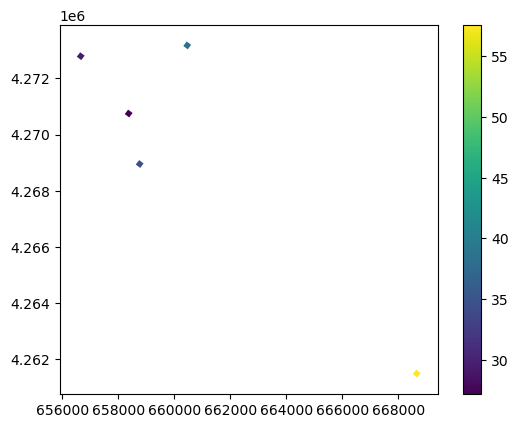

In [135]:
hob_dir = gwfm_dir+'/HOB_data'
# save cleaned data to box data for all data
all_obs = pd.read_csv(hob_dir+'/all_obs_grid_prepared.csv',index_col=0,parse_dates=True)
hill_obs = all_obs[all_obs.column>200].groupby('site_code').mean(numeric_only=True)
hill_obs
hill_grid = grid_p[grid_p.column>200][['row','column','geometry']]
hill_grid[['row','column']]-=1
hill_grid = hill_grid.join(hill_obs.set_index(['row','column']),on=['row','column'],how='inner')
hill_grid.plot('gwe',legend=True)

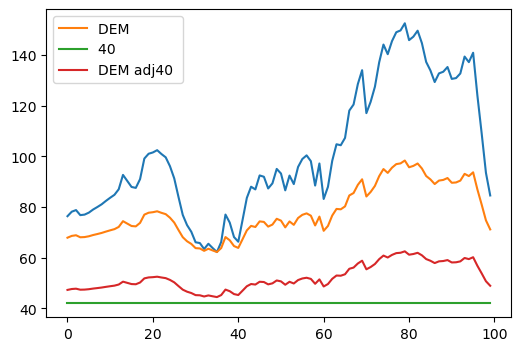

In [136]:
# Determine which layer the specified head cell is in
# since the if statement only checks whether the first layer is greater than the streambed elevation, 
# otherwise it would be less than and zero (most should be in layer 0)

fig,ax=plt.subplots( figsize=(6,4))
ax.plot(dem_data[:,ncol-1])

chd_lay = np.zeros(nrow)

head = dem_data[:,ncol-1]
headmin = np.min(head)
ch_weight = 0.6
chd_vals = head*(1-ch_weight)+headmin*ch_weight
ax.plot(chd_vals,label='DEM ')

ch_weight = 0.8
chd_vals = np.full(dem_data[:,ncol-1].shape,42)
ax.plot(chd_vals,label='40 ')

chd_vals = head*(1-ch_weight)+40*ch_weight
ax.plot(chd_vals,label='DEM adj40 ')
plt.legend()

chd_lay2 = get_layer_from_elev(chd_vals, botm[:, :, -1], m.dis.nlay)


In [137]:
# layer (int), row (int), column (int), shead (float), ehead (float) shead is the head at the
# start of the stress period, and ehead is the head at the end of the stress period
# nlay_ghb = 1

# constant head boundary for mountain front recharge
# assume that near the mountains the head should be at the surface becaues the aquifer is thin

# new specified head boundary will be linear at the uppermost column to reduce nonlinearity
# as the no flow cells will be removed and replaced with low hydraulic conductivity cells

# chd_spd = np.zeros((len(chd_locs[0]),5))
chd_spd = np.zeros((int(np.sum((nlay-chd_lay))),5))

# use simple 42 m value to simplify input complexity
chd_vals = np.full(dem_data[:,ncol-1].shape,42)

# # head for mountain front recharge
shead = chd_vals
ehead = chd_vals
p=0
for i in np.arange(0,nrow):
    for k in np.arange(0,nlay-chd_lay[i]):
        chd_spd[p] = [int(chd_lay[i]+k), i, ncol-1, shead[i], ehead[i]]
        p+=1
print('Number of CHD cells for upland bound', p)


Number of CHD cells for upland bound 1900


In [138]:
chd.stress_period_data =  {0: chd_spd}

In [139]:
chd.check()
# chd.write_file()


CHD PACKAGE DATA VALIDATION:
  No errors or warnings encountered.

  Checks that passed:
    BC indices valid
    not a number (Nan) entries
    BC in inactive cells



## RCH Package
1. Load in already interpolated ET and rainfall data
2. Determine where there is agricultural land to add irrigation multiplied by an efficiency factor to the rainfall array
3. Difference the rainfall and ETc arrays to dtermine how much water will recharge the aquifer

In [140]:
import h5py
uzf_dir = join(gwfm_dir, 'UZF_data')
nrow_p, ncol_p = 100,230


Use updated ETc based on DWR land use

In [141]:
def dwr_etc(strt_date, end_date):
    nper_tr = (end_date-strt_date).days+1
    natETc = np.zeros((nper_tr,nrow_p,ncol_p))
    agETc = np.zeros((nper_tr,nrow_p,ncol_p))

    per_n = 0 
    for y in np.arange(strt_date.year, end_date.year+1):
        # set start and end date for range for the year to be iterated over
        yr_strt = pd.to_datetime(str(y)+'-01-01')
        yr_end = pd.to_datetime(str(y)+'-12-31')
        # get the length of the date range needed for that year
        yearlen = len(pd.date_range(yr_strt, yr_end))
        if yr_strt < strt_date:
            yr_strt = strt_date
        if yr_end > end_date:
            yr_end = end_date
        yr_len = len(pd.date_range(yr_strt, yr_end))
        # load hdf5 files
        f_irr = h5py.File(join(uzf_dir, "dwr_ETc/irrigated_"+str(y)+".hdf5"), "r")
        agETc[per_n:per_n+yr_len,:,:] = f_irr['array'][str(y)][:][yr_strt.dayofyear-1:yr_end.dayofyear,:,:]
        f_irr.close()
        f_nat = h5py.File(join(uzf_dir, "dwr_ETc/native_"+str(y)+".hdf5"), "r")
        natETc[per_n:per_n+yr_len,:,:] = f_nat['array'][str(y)][:][yr_strt.dayofyear-1:yr_end.dayofyear,:,:]
        f_nat.close()
        per_n += yr_len
    # make sure the return value is separate from the loop
    return(agETc, natETc)

In [245]:
## Potential ETo spatial interpolation from CIMIS
fn = glob.glob(join(uzf_dir,'CIMIS','Cosumnes_dailyET_precip*.csv'))
daily_data = pd.DataFrame()
for file in fn:
    new_data = pd.read_csv(file, index_col = ['Date'], parse_dates = True)
    daily_data = pd.concat((daily_data, new_data))
# units of mm
data_in = daily_data[daily_data['Stn Name']=='Fair Oaks']
# clean up data so columns are by location, units of Precip are in mm
rain_in = data_in.pivot_table(index = 'Date', columns = 'Stn Name', values = 'Precip (mm)')
rain_m = rain_in/1000
# clean up data so columns are by location, units of Precip are in mm
ETo_in = data_in.pivot_table(index = 'Date', columns = 'Stn Name', values = 'ETo (mm)')
ETo_m = ETo_in/1000

# create array for every period of rainfall
rain_df = rain_m[strt_date:end_date].resample('D').interpolate('zero')['Fair Oaks']
rain_arr = np.repeat(np.repeat(np.reshape(rain_df.values, (rain_df.shape[0],1,1)), nrow, axis=1),ncol, axis=2)


# create array for every steady state period of rainfall
rain_df = rain_m[ss_strt:strt_date].resample('D').interpolate('zero')['Fair Oaks']
rain_arr_ss = np.repeat(np.repeat(np.reshape(rain_df.values, (rain_df.shape[0],1,1)), nrow, axis=1),ncol, axis=2)
rain_arr_ss = rain_arr_ss.mean(axis=0)

In [246]:
agETc, natETc = dwr_etc(strt_date, end_date)
# net ETc should be ETc from ag and native plants joined
ETc = agETc + natETc

In [247]:
ss_agETc, ss_natETc = dwr_etc(ss_strt, strt_date)
ss_ETc = ss_agETc+ss_natETc

# EVT Package
The lower Cosumnes contains rigegions where the water table rises enough for GDEs to use groundwater. The foothills also may see some limited groundwater use.

In [145]:
gde_dir = join(uzf_dir,'shp_GDE_TFT')

# locations of GDes and native vegetation
# the pre-calculated rooting depth assumes deeper roots for GDEs than regular natives
GDE_all = gpd.read_file(join(gde_dir,'GDE_and_native_cell.shp'))

In [146]:
# convert rooting depth to array format for modflow input, hydrographs in wells show drawdown to about 10 m
# below ground so should use 10 m for all gde
ext_dp = np.full((nrow,ncol),2)
ext_dp[(GDE_all.row-1).astype(int), (GDE_all.column-1).astype(int)] = GDE_all.rtg_dp

In [147]:
def set_evt(ETc, agETc):
    # the EVT package uses flux instead of rates
    evtr = np.copy(ETc)*delr*delc
    # remove evapotranspiration in stream cells
    evtr[:, sfr_rows, sfr_cols] = 0
    # remove pumping in cells where GHB is connected
    evtr[:, bnd_rows, bnd_cols] = 0
    # remove ET where there is agriculture
#     evtr[agETc>0] = 0
    ## where dtw is on minimum >10 m (GSP number is 30 ft) don't set ET 
    # use the year with max elev to insure that extreme years are captured
    avg_dtw = dem_data - np.max(kriged_arr,axis=0)
    evtr[:, avg_dtw> 10] = 0
    # remove ET in foothills
    evtr[:,:, adj_lowK.loc[0]:] = 0
    return(evtr)

In [274]:
# the EVT package uses flux instead of rates
evtr = set_evt(ETc, agETc)
ss_evtr = set_evt(ss_ETc, ss_agETc)

In [275]:

# have transient et start after the 1st spd
et_spd = { (j): evtr[j-1,:,:] for j in np.arange(time_tr0,nper)}

if ss_bool == True:
    et_spd[0] = ss_evtr.mean(axis=0)


In [277]:
# calculate ET layer
et_rows, et_cols = np.where(ext_dp>0)
et_layer = get_layer_from_elev((dem_data - ext_dp)[et_rows, et_cols], m.dis.botm.array[:, et_rows, et_cols], m.dis.nlay)
ievt = np.zeros((nrow,ncol))
ievt[et_rows, et_cols] = et_layer
# I checked that these are all active cells in ibound

Removing excess EVT (by ag and dtw) reduced WB error slightly (200% to 60%), next step was to remove the foothills and specify nevtop = 2 to avoid extra MF calculations. Removing foothills and changing nevtop brought error to 28.6%

In [278]:

# surf : et surface elevation. evtr: maximum ET flux
# exdp: extinction depth. ievt : layer indicator variable
# nevtop = 3 -> highest active layer
# nevtop = 2 -> layer defined in ievt
evt = flopy.modflow.ModflowEvt(model=m, nevtop = 2, ievt = ievt, 
                               evtr = et_spd, exdp = ext_dp,  
                               surf = dem_data, ipakcb = 55)



In [279]:
# evt.write_file()

## Pre-processed percolation
Calculated with an explicity soil water budget including runoff, evapotranspiration and percolation applied in order to avoid iterative solving. The parameters are all based on SSURGO data, the calculated percolation should be scaled by the VKA to avoid excess percolation.

In [154]:
years = pd.date_range(strt_date,end_date+pd.DateOffset(years=1),freq='AS-Oct')
yr_ind = (years-strt_date).days
years = years[:-1]
n=6
# years[n]

In [218]:
# import importlib
# import swb_utility
# importlib.reload(swb_utility)

<module 'swb_utility' from 'C:\\Users\\ajcalder\\Documents\\GitHub/CosumnesRiverRecharge/python_utilities\\swb_utility.py'>

In [221]:
from swb_utility import load_swb_data

In [224]:
# def load_swb_data(strt_date, end_date, param):
#     nper_tr = (end_date-strt_date).days+1
#     # years and array index 
#     # include final year for specifying index then drop
#     years = pd.date_range(strt_date,end_date+pd.DateOffset(years=1),freq='AS-Oct')
#     yr_ind = (years-strt_date).days
#     years = years[:-1]
#     perc = np.zeros((nper_tr, nrow_p,ncol_p))
#     # need separte hdf5 for each year because total is 300MB
#     for n in np.arange(0,len(years)):
#     #     arr = pc[yr_ind[n]:yr_ind[n+1]]
#         fn = join(uzf_dir, 'basic_soil_budget',param+"_WY"+str(years[n].year+1)+".hdf5")
#         with h5py.File(fn, "r") as f:
#             arr = f['array']['WY'][:]
#             perc[yr_ind[n]:yr_ind[n+1]] = arr
#     return(perc)



In [439]:
pd.to_datetime(m.dis.start_datetime)
(strt_date + pd.Series(m.dis.perlen.array[:-1].sum()).astype('timedelta64[D]'))[0]
# m.dis.perlen.array


Timestamp('2020-09-30 00:00:00')

In [234]:
perc = load_swb_data(strt_date, end_date, 'field_percolation', uzf_dir)
# perc = load_swb_data(strt_date, end_date, 'percolation')
# percolation can't exceed vertical conductivity (secondary runoff)
perc = np.where(perc >vka[0,:,:], vka[0,:,:], perc)

ss_perc = load_swb_data(ss_strt, strt_date-pd.DateOffset(days=1), 'field_percolation', uzf_dir)
# percolation can't exceed vertical conductivity (secondary runoff)
ss_perc = np.where(ss_perc >vka[0,:,:], vka[0,:,:], ss_perc)

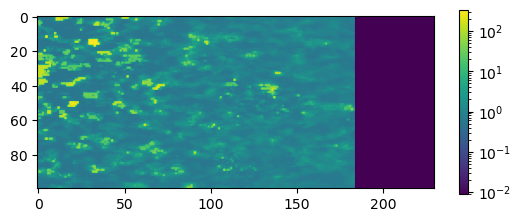

In [326]:
plt.imshow(vka[0,:,:], norm = mpl.colors.LogNorm())
plt.colorbar(shrink=0.5)

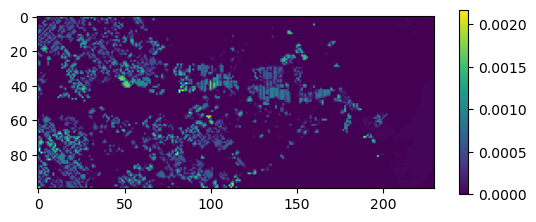

In [327]:
plt.imshow(ss_perc.mean(axis=0))
plt.colorbar(shrink=0.5)

In [156]:
# load applied water from soil water budget
# it is the ETc scaled by irrigation efficiencies
# AW = load_swb_data(strt_date, end_date, 'applied_water')
# AW_ss = load_swb_data(ss_strt, strt_date-pd.DateOffset(days=1), 'applied_water')


In [237]:
AW = load_swb_data(strt_date, end_date, 'field_applied_water', uzf_dir)
AW_ss = load_swb_data(ss_strt, strt_date-pd.DateOffset(days=1), 'field_applied_water', uzf_dir)


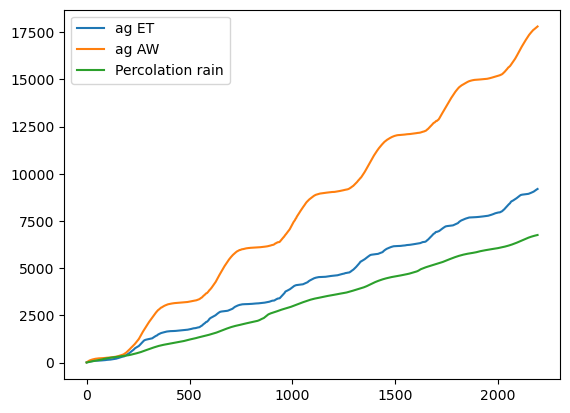

In [239]:
plt.plot(agETc.sum(axis=(1,2)).cumsum(),label='ag ET')
plt.plot(AW.sum(axis=(1)).cumsum(),label='ag AW')
# plt.plot(natETc.sum(axis=(1,2)).cumsum(),label='native ET')

plt.plot(perc.sum(axis=(1,2)).cumsum(), label='Percolation rain')

plt.legend()
plt.show()
# 

In [240]:
# where GDEs are active the rain should be directly applied instead of SWB percolation
# as we don't want to double count ET
adj_perc = perc.copy()
adj_perc[:, ext_dp>2] = rain_arr[:, ext_dp>2]

adj_perc_ss = ss_perc.copy().mean(axis=0)
adj_perc_ss[ext_dp>2] = rain_arr_ss[ext_dp>2]

In [241]:
# have transient recharge start after the 1st spd
rech_spd = {}

if ss_bool == True:
#     rech_spd[0] = ss_perc.mean(axis=0)
    rech_spd[0] = adj_perc_ss

for j in np.arange(time_tr0,nper):
#     rech_spd[j] = perc[j-time_tr0,:,:] 
    rech_spd[j] = adj_perc[j-time_tr0,:,:] 

# nrchop = 3, to highest active cell
rch = flopy.modflow.ModflowRch(model = m, nrchop=3, rech = rech_spd, ipakcb=55)

In [242]:
# rch.write_file()

Errors and/or Warnings encountered.
  see F:/WRDAPP/GWFlowModel/Cosumnes/Regional/historical_simple_geology_reconnection\RCH.chk for details.



One option for the foothills is to implement the drain package to avoid heads above land because especially in high slope areas that would tend to drain off to upper watershed streams/creeks.

## Well Package
Any input files that are saved externally as a csv should be kept as 1 based row,column but once they are loaded into python it is acceptable to maintain them as zero based.

In [161]:
wel_dir = join(gwfm_dir,'WEL_data')

In [162]:
wells = pd.read_csv(wel_dir+'/all_wells_type.csv')
wells_grid = gpd.GeoDataFrame(wells, geometry = gpd.points_from_xy(wells.easting,wells.northing), crs = 'epsg:32610')
# remove wells that didn't exist before model start date, could improve later to start pumping mid-model
wells_grid.DateWorkEnded = pd.to_datetime(wells_grid.DateWorkEnded, errors='coerce' )
wells_grid['well_age_days'] = (strt_date - wells_grid.DateWorkEnded).dt.days

# if wells_grid.row.min()==1:
# new version, keep 1 based wells grid, add new columns to do 0 based
wells_grid.row = (wells_grid.row-1).astype(int)
wells_grid.column = (wells_grid.column -1).astype(int)

wells_grid['depth_m'] = wells_grid.TotalCompletedDepth*0.3048
wells_grid['flux'] = 0
wells_grid['layer'] = 0

In [163]:
ag_well_depth_arr = np.loadtxt(wel_dir+'/ag_well_depth_arr.tsv', delimiter='\t')

In [164]:
wel_bot_elev = dem_data[wells_grid.row, wells_grid.column] - wells_grid.depth_m
wells_grid['layer'] = get_layer_from_elev(wel_bot_elev, botm[:,wells_grid.row, wells_grid.column], m.dis.nlay)

In [165]:
# assume each public supply well serves 5-10,000 people each needing 50 gpd, then need to convert to ft^3
public_flux = (5000*50/7.48)*(0.3048**3)

# define pumping rate based on well use, average pumping rate in m^3/day
wells_grid.loc[wells_grid.Simple_type == 'public', 'flux'] = -public_flux



In [166]:
# pull out public wells for input
wells_public = wells_grid[wells_grid.Simple_type=='public'][['layer','row','column', 'flux']]

# Domestic pumping, missing water surface
- Added pumping from domestic wells based on parcel data
- Add pumping for water surface that was included because it is known to be supplied by groundwater (satellite imagery), Laguna del Sol recreation lake, golf course ponds, fish farms.

In [167]:
# load prepared daily domestic use data
dom_use = pd.read_csv(join(wel_dir, 'domestic_water_use.csv'), index_col=0, parse_dates=True)
dom_use = dom_use[strt_date:end_date]

# load data of locations of domestic wells
dom_loc = pd.read_csv(join(wel_dir, 'ag_res_parcel_domestic_wells.csv'), index_col=0)
# make row,column 0 based
dom_loc.row = (dom_loc.row-1).astype(int)
dom_loc.column = (dom_loc.column -1).astype(int)
# aggregate to the cell level, summing area will keep water usage scaling correct
dom_loc = dom_loc.groupby(['node','row','column', 'CITY']).sum(numeric_only=True).reset_index()
# get domestic well layers
dom_wel_bot = (dem_data[dom_loc.row, dom_loc.column]- dom_loc.fill_depth_m).values
dom_loc['layer'] = get_layer_from_elev(dom_wel_bot, botm[:,dom_loc.row, dom_loc.column], m.dis.nlay)

# use either the total area or expected fraction of irrigated area
# dom_loc['pump_scale'] = dom_loc.used_area_acres
dom_loc['pump_scale'] = dom_loc.area_acres
# since there appear to be higher pumping rates in wilton/sloughhouse based on observations
# i'm going to try different pumping scaling factors
# 2 times seemed like too much
# dom_loc.loc[dom_loc.CITY.isin(['WILTON']),'pump_scale'] *= 1.5 #'SLOUGHHOUSE'

In [168]:
# dom_grid = grid_p.set_index(['row','column']).loc[list(zip(dom_loc.row+1, dom_loc.column+1))]
dom_grid = grid_p.merge(dom_loc,on=['row','column'])

In [169]:

# for each stress period specify the flux of parcels from the expected domestic well flux time series
# multiply by scaling factor based on parcel size
dom_loc['flux'] = -dom_use.flux_m3d.mean()*dom_loc.pump_scale
wells_dom = dom_loc[['layer','row','column','flux']].values
spd_noag = np.vstack((wells_dom, wells_public))

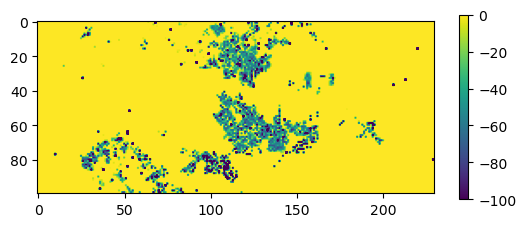

In [170]:
temp = np.zeros((nrow,ncol))
temp[spd_noag[:,1].astype(int), spd_noag[:,2].astype(int)] = spd_noag[:,3]
plt.imshow(temp, vmin=-100)
plt.colorbar(shrink=0.5)

Add pumping from fish farms and other small water surfaces on the south side of the cosumnes that are filled with groundwater use.

In [243]:
# the coefficient for open water is 1.2 at all times
ET_water = ETo_m[strt_date:end_date]*1.2

water_surf = gpd.read_file(join(uzf_dir,'county_landuse','ag_lu_locally_defined.shp'))
water_surf = gpd.overlay(water_surf, grid_p)
water_surf['area_m2'] = water_surf.geometry.area
# make row,column 0 based
water_surf.row = (water_surf.row-1).astype(int)
water_surf.column = (water_surf.column -1).astype(int)
# determine layer
water_surf['depth_m'] = ag_well_depth_arr[water_surf.row, water_surf.column]
wel_bot_elev = dem_data[water_surf.row, water_surf.column] - water_surf.depth_m
water_surf['layer'] = get_layer_from_elev(wel_bot_elev, botm[:,water_surf.row, water_surf.column], m.dis.nlay)

In [244]:
# for each stress period specify the flux of water surfaces 
water_surf['flux'] = -ET_water['Fair Oaks'].mean()*water_surf.area_m2
wells_ws = water_surf[['layer','row','column','flux']].values
spd_noag = np.vstack((wells_dom, wells_public, wells_ws))

### Calculate layers for Ag wells then public/domestic
Dependent on m.dis.botm

In [174]:
ag_screen_botm = np.where(dem_data-ag_well_depth_arr<top_botm)
ag_screen_botm = np.rot90(np.vstack(ag_screen_botm))
ag_screen_botm = pd.DataFrame(ag_screen_botm, columns=['layer','row','column'])
ag_max_lay = ag_screen_botm.groupby(['row','column']).max()
# any wells below most bottom go in bottom layer
ag_max_lay.layer[ag_max_lay.layer == nlay] = nlay-1

# assume 10% of well is screened? Pauloo? tprogs lay thickness is 4m, so 12ft, not quite enough for typical well?
# if we go two layers we have 8 m which is near the average expected well screen
ag_screen_top = np.where((dem_data-ag_well_depth_arr*0.9)<=top_botm)
ag_screen_top = np.rot90(np.vstack(ag_screen_top))
ag_screen_top = pd.DataFrame(ag_screen_top, columns=['layer','row','column'])
ag_min_lay = ag_screen_top.groupby(['row','column']).max()
ag_min_lay.layer[ag_min_lay.layer == nlay] = nlay-1


In [175]:
print('Cells with wells: ', wells_grid.dissolve(by='node',aggfunc='first').shape[0], 'total wells: ', wells_grid.shape[0])
print('Wells with TRS accuracy: ', (wells_grid.MethodofDeterminationLL == 'Derived from TRS').sum())

wells_grid_notrs = wells_grid.loc[wells_grid.MethodofDeterminationLL != 'Derived from TRS']

Cells with wells:  1380 total wells:  2482
Wells with TRS accuracy:  823


In [176]:
# plt.imshow(AW.mean(axis=0))
# plt.colorbar(shrink=0.5)
# plt.show()
# plt.imshow(agETc.mean(axis=0))
# plt.colorbar(shrink=0.5)

Originally applied just the ETc, new code applies applied water which is ETc scaled by irrigation efficiency.  

In [248]:
# already filtering by land type above
# ET_ag = np.copy(agETc)
ET_ag = np.copy(AW)

if ss_bool == True:
#     ET_ag_SS = np.reshape(ss_agETc.mean(axis=0),(1, nrow,ncol))
    ET_ag_SS = np.reshape(AW_ss.mean(axis=0),(1,AW.shape[0])) #(1, nrow,ncol))
    ET_ag = np.concatenate((ET_ag_SS, ET_ag), axis=0)

#### Using ETc in all cells for pumping

In [250]:
# old version in array format
# simplified ag well layer with just one layer per well
# ag_row, ag_col = np.where(ET_ag.sum(axis=0)>0)
# ag_well_lay = get_layer_from_elev((dem_data-ag_well_depth_arr*0.9)[ag_row, ag_col], 
#                                   botm[:, ag_row, ag_col], m.dis.nlay)
# ag_well_lay.shape, ag_row.shape
# ag_well_lay = pd.DataFrame(np.transpose((ag_row,ag_col, ag_well_lay)), columns=['row','column','layer'])

In [309]:
# new version with 1 well for a field or multiple fields
lu_wells = gpd.read_file(join(wel_dir, 'ag_fields_to_wells', 'ag_fields_to_wells.shp'))
fields = pd.read_csv(join(uzf_dir, 'clean_soil_data', 'fields_output_reference.csv'))

In [311]:
# extract applied water estimates where we have a known irrigaton type
AW_irr = AW[:, fields.irr_name != 'no irrig']
AW_ss_irr = AW_ss[:, fields.irr_name != 'no irrig'].mean(axis=0)

fields_irr = fields[fields.irr_name != 'no irrig']

In [312]:
# identify the well to the field area
fields_well = pd.merge(fields_irr[['geom_id','name','irr_name','field_area_m2']],
         lu_wells[['geom_id','name','irr_name','row','column', 'depth_m', 'dist_m']], 
          how='left')

fields_spd = fields_well[['depth_m','row','column','field_area_m2']].copy()
fields_spd[['row','column']] -=1
frow = fields_spd.row
fcol = fields_spd.column
fields_spd['layer'] = get_layer_from_elev(dem_data[frow,fcol] - fields_spd.depth_m*0.9, botm[:, frow,fcol], m.dis.nlay)


In [313]:
wel_ETc_dict = {}
fields_spd['flux'] = -AW_ss_irr*fields_spd.field_area_m2
if ss_bool:
    fields_dict[0] = fields_spd[['layer','row','column','flux']].values
    
for n,d in enumerate(dates):
    AW_spd = AW_irr[n]
    fields_spd['flux'] = -AW_spd*fields_spd.field_area_m2
    wel_ETc_dict[n+time_tr0] = fields_spd[['layer','row','column','flux']].values

In [179]:

# iterate over all row, col and get layers for each well based on "screen" 
# ag_well_lay = np.zeros((1,3))
# for i,j in zip(ag_min_lay.reset_index().row,ag_min_lay.reset_index().column):
#     lays = np.arange(ag_min_lay.layer.loc[i,j],ag_max_lay.layer.loc[i,j]+1)
#     ijk = np.rot90(np.vstack((np.tile(i,len(lays)), np.tile(j,len(lays)),lays)))
#     ag_well_lay = np.vstack((ag_well_lay,ijk))
# # delete filler first row
# ag_well_lay = ag_well_lay[1:]
# ag_well_lay = pd.DataFrame(ag_well_lay.astype(int), columns=['row','column','layer'])

# num_ag_layers = (ag_max_lay - ag_min_lay+1).reset_index()
# # divide ET_ag by the number of layers it will go into
# ET_ag_layered = np.copy(ET_ag)
# ET_ag_layered[:,num_ag_layers.row,num_ag_layers.column] /= num_ag_layers.layer.values

In [180]:
# used by the array AW method, not needed when done by field
# adjustments to allow connection with rows,cols with pumping
# row_col = ag_well_lay.loc[:,['row','column']].rename({'row':'rowi','column':'colj'},axis=1)
# ag_well_lay = ag_well_lay.set_index(['row','column'])
# ag_well_lay['rowi'] = row_col.rowi.values
# ag_well_lay['colj'] = row_col.colj.values

In [181]:
# used by the array AW method, not needed when done by field

# create empty dictionary to fill with stress period data
# wel_ETc_dict = {}
# # end date is not included as a stress period, starting at 1st TR spd (2)
# for t in np.arange(0,nper):
#     wel_i, wel_j = np.where(ET_ag[t, :, :]>0)
#     new_xyz = ag_well_lay.loc[list(zip(wel_i,wel_j))] 
# #     wel_ETc = -ET_ag[t-1,wel_i,wel_j]*delr*delr
# # use new row,cols because there are more layers to use
# #     wel_ETc = -ET_ag_layered[t, new_xyz.rowi, new_xyz.colj]*delr*delr
#     wel_ETc = -ET_ag[t, new_xyz.rowi, new_xyz.colj]*delr*delr
#     # ['layer','row','column', 'flux'] are necessary for WEL package
#     spd_ag = np.stack((new_xyz.layer, new_xyz.rowi, new_xyz.colj,wel_ETc),axis=1)
#     # correct by dropping any rows or cols without pumping as some may be added
#     spd_ag = spd_ag[spd_ag[:,-1]!=0,:]
#     spd_all = np.copy(spd_ag)
#     wel_ETc_dict[t] = spd_all

In [314]:
wel_dict = {}
for t in np.arange(time_tr0, nper):
    # for each stress period specify the flux of parcels from the expected domestic well flux time series
    dom_loc['flux'] = - dom_use.loc[dates[t-time_tr0],'flux_m3d']*dom_loc.pump_scale
    wells_dom = dom_loc[['layer','row','column','flux']].values
    # for each stress period specify the flux of water surfaces 
    water_surf['flux'] = -ET_water.loc[dates[t-time_tr0],'Fair Oaks']*water_surf.area_m2
    wells_ws = water_surf[['layer','row','column','flux']].values
    spd_noag = np.vstack((wells_dom, wells_ws))
    spd_all = np.vstack((wel_ETc_dict[t],spd_noag)) 
    wel_dict[t] = spd_all
    
if ss_bool:
    dom_loc['flux'] = - dom_use['flux_m3d'].mean()*dom_loc.pump_scale
    wells_dom = dom_loc[['layer','row','column','flux']].values
    # for each stress period specify the flux of water surfaces 
    water_surf['flux'] = -ET_water['Fair Oaks'].mean()*water_surf.area_m2
    wells_ws = water_surf[['layer','row','column','flux']].values
    spd_noag = np.vstack((wells_dom, wells_ws))
    spd_all = np.vstack((wel_ETc_dict[0],spd_noag)) 
    wel_dict[0] = spd_all

In [315]:
# Create well flopy object
wel = flopy.modflow.ModflowWel(m, stress_period_data=wel_dict,ipakcb=55)

In [316]:
# wel.write_file()
# wel.check()

In [ ]:
# convert pumping to array
pump = np.zeros((m.dis.nper,m.dis.nrow,m.dis.ncol))
for n in np.arange(0,m.dis.nper):
    wel_n = m.wel.stress_period_data[n]
    pump[n, wel_n.i, wel_n.j] += wel_n.flux*-1
pump_rate = pump/(m.dis.delr[0]*m.dis.delc[0])


In [ ]:
pump_avg_sum = pump_rate.mean(axis=0).sum()*200*200

In [ ]:
rch_avg_sum = rch.rech.array.mean(axis=0)[0].sum()*200*200
pump_avg_sum/rch_avg_sum

In [ ]:
# n=1
# plt.imshow(perc[1+365*n:1+365*(n+1)].sum(axis=0))
# plt.show()
# plt.imshow(pump_rate[1+365*n:1+365*(n+1)].sum(axis=0))
# plt.show()

## HOB Package

In [184]:
hob_dir = gwfm_dir+'/HOB_data'

In [358]:
# load cleaned data from box data, lengths are in meters
all_obs = pd.read_csv(hob_dir+'/all_obs_grid_prepared.csv') #,index_col='date', parse_dates=['date'])
# all_obs = pd.read_csv(hob_dir+'/all_obs_grid_prepared_auto_QAQC.csv',index_col='date', parse_dates=True)
# remove date time portion since regional model is daily scale, subdaily variation isn't critical
if (all_obs.date is object):
    all_obs['date'] = all_obs.date.str.extract(r'(\d{4}-\d+-\d+)')
all_obs.date = pd.to_datetime(all_obs.date, errors='coerce')

all_obs = all_obs.set_index('date')
all_obs = all_obs.loc[(all_obs.index>strt_date)&(all_obs.index<end_date)]

# # # get spd corresponding to dates
all_obs['spd'] = (all_obs.index-strt_date).days.values


In [359]:
# any well with less than 2 measurements per year the period should not be used
# difference between 2 and 4 measurements dropped is only 3 more wells so conservative is better
hob_min = int(2*nper/365)-2
# wells to be used in calibration
hob_use = all_obs.site_code.unique()[(all_obs.groupby('site_code').count()>hob_min)["gwe"].values]
print('Number of wells droppped', all_obs[~all_obs.site_code.isin(hob_use)].site_code.unique().shape[0])
print('Number of wells kept',all_obs[all_obs.site_code.isin(hob_use)].site_code.unique().shape[0])

all_obs = all_obs[all_obs.site_code.isin(hob_use)]

Number of wells droppped 13
Number of wells kept 57


In [360]:
if all_obs.avg_screen_depth.isna().sum()>0:
    print('Some OBS missing screen depth')

all_obs['screen_elev'] = dem_data[all_obs.row-1, all_obs.column-1] - all_obs.avg_screen_depth
# keep 1 based layer
all_obs['layer'] = get_layer_from_elev(all_obs.screen_elev, botm[:,all_obs.row-1, all_obs.column-1], m.dis.nlay) + 1

<Axes: >

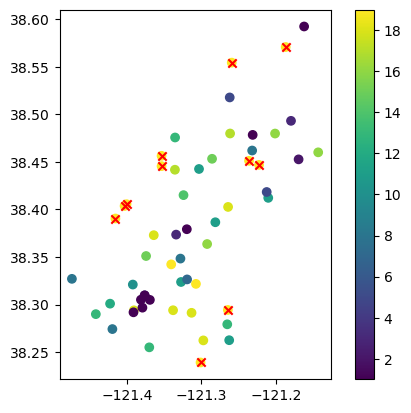

In [361]:
stns = all_obs.drop_duplicates('site_code', keep='last').reset_index().drop(columns=['date','gwe'])
stns = gpd.GeoDataFrame(stns, geometry = gpd.points_from_xy(stns.longitude, stns.latitude),crs='epsg:4326')
stns['botm_elev'] = botm[stns.layer-1, stns.row-1, stns.column-1]

fig,ax = plt.subplots()
stns.plot('layer',legend=True,ax=ax)
# wells below the model bottom
stns[stns.botm_elev > stns.screen_elev].plot(color='red',marker='x',ax=ax)

In [362]:
# drop wells that are well below the model bottom (10%)
deep_wells = stns[stns.botm_elev > stns.screen_elev*0.9].node.values
all_obs_out = all_obs[~all_obs.node.isin(deep_wells)]

In [363]:
# save cleaned data to input data for post-processing
all_obs_out.to_csv(model_ws+'/input_data/all_obs_grid_prepared.csv')

In [364]:
dwr_site_codes = all_obs_out.site_code.unique()

# create a new hob object
obs_data = []
dwr_spd_wse = all_obs_out.loc[:,['site_code','spd','gwe']]
for i in np.arange(0,len(dwr_site_codes)): # for each well location
    # time_series_data needs stress period in col 0 and WSE in col 1
    # the row and column are already one based as they come from grid_p
    # need to return and adjust layer later, for now layer 2 should be good so that it doesn't go dry
    # get stress period data and water surface elevation for well
    dwr_site = all_obs.set_index('site_code').loc[dwr_site_codes[i]]
    if dwr_site.ndim >1:
        row = dwr_site.row.values[0]
        col = dwr_site.column.values[0]
        layer = dwr_site.layer.values[0]
        names = dwr_site.obs_nam.tolist()
        obsname = 'N'+str(dwr_site.node.values[0])
    else:
        row = dwr_site.row
        col = dwr_site.column
        layer = dwr_site.layer
        names = dwr_site.obs_nam
        obsname = 'N'+str(dwr_site.node)
        
    tsd = dwr_spd_wse.set_index('site_code').loc[dwr_site_codes[i]].values
    # need to minus 1 for grid_p which is 1 based
    temp = flopy.modflow.HeadObservation(m, layer=layer-1, row=row-1, 
                                                  column=col-1,
                                                  time_series_data=tsd,
                                                  obsname=obsname, names = names)
    # correct time offset from stress period to be 0
    temp.time_series_data['toffset'] = 0
    obs_data.append(temp)


In [365]:
hob = flopy.modflow.ModflowHob(m, iuhobsv=50, hobdry=-9999., obs_data=obs_data, unitnumber = 39,
                              hobname = 'MF.hob.out')

In [ ]:
# hob.write_file()

In [ ]:
# find nearest boundary cell to the HOB points
hob_bnd = gpd.sjoin_nearest(stns.to_crs(bnd_cells_df.crs).drop(columns=['row','column']),
                            bnd_cells_df[['row','column','geometry']], how='left')
hob_bnd[['row','column']] -=1
# get the heads for each
hob_ghb = hob_bnd.merge(df_mon.reset_index().drop_duplicates(['row','column', 'date']), on=['row','column'])


In [ ]:
hob_select = hob_ghb[hob_ghb.node.isin([15314, 15343, 13407, 12944, 14626])]
# hob_select
# hob_long = hob_select.melt(value_vars=['value','WSE'], id_vars=['node'], ignore_index=False)

# sns.relplot(hob_select, x='date',y='value', 
#             col='node',
#             col_wrap=4,
#            facet_kws={'sharex':True, 'sharey':False})

# Stream Gage outflow

In [ ]:
sensors = pd.read_csv(gwfm_dir+'/Mapping/allsensor_latlong.csv')
sensors = gpd.GeoDataFrame(sensors,geometry=gpd.points_from_xy(sensors.Longitude, sensors.Latitude))
sensors.crs = 'epsg:4326'
sensors = sensors.to_crs('epsg:32610')
mcc_grid = gpd.sjoin(sensors[sensors.Site_id=='MCC'],xs_sfr)
mcc_grid.columns

In [ ]:
# numgage is total number of gages
# gage_data (list, or array), includes 2 to 3 entries (LAKE -UNIT (OUTTYPE)) for each LAK entry
#  4 entries (GAGESEG, GAGERCH, UNIT, OUTTYPE) for each SFR package entry

mcc_gage_data = [[mcc_grid.iseg, mcc_grid.reach, 37, 1]]
gage_file = 'MF.gage'
mcc_file_out = 'MF_mcc.go' # not recognized still
gag = flopy.modflow.ModflowGage(model=m,numgage= 1,gage_data=mcc_gage_data,
                                filenames =[gage_file,mcc_file_out])


In [ ]:
# gag.write_file()
# m.write_name_file()

## Output Control

In [ ]:
# Output control
# default unit number for heads is 51, cell by cell is 53 and drawdown is 52
# (0,0) is (stress period, time step)

# get the first of each month to print the budget
month_intervals = (pd.date_range(strt_date,end_date, freq="MS")-strt_date).days
spd = {}
# output file for parallel runs when head/cbc is not needed
for j in month_intervals:
    spd[j,0] = ['print budget']
oc = flopy.modflow.ModflowOc(model = m, stress_period_data = spd, compact = True, filenames='MF_parallel.oc')
oc.write_file()


# For later model runs when all the data is needed to be saved
spd = {}
# spd = { (j,0): ['save head', 'save budget'] for j in np.arange(0,nper,1)}
spd = { (j,0): ['save head'] for j in np.arange(0,nper,1)}

for j in month_intervals:
#     spd[j, 0] = ['save head', 'save budget','print budget']
    spd[j, 0] = ['save head', 'print budget']
    
oc = flopy.modflow.ModflowOc(model = m, stress_period_data = spd, compact = True)

In [ ]:
# oc.write_file()

## Newton Solver

In [ ]:
nwt = flopy.modflow.ModflowNwt(model = m, headtol=1E-4, fluxtol=500, maxiterout=200, thickfact=1e-05, 
                               linmeth=1, iprnwt=1, ibotav=0, options='Specified', Continue = True)
nwt_dict = nwt.__dict__

# load in parameters used by margaret shanafield for DFW
nwt_ex = pd.read_csv(gwfm_dir+'/Solvers/nwt_solver_input_from_dfw.csv', comment='#')
nwt_ex['nwt_vars'] = nwt_ex.NWT_setting.str.lower()
nwt_ex = nwt_ex.set_index('nwt_vars')
nwt_ex = nwt_ex.dropna(axis=1, how='all')
# nwt_ex.select_dtypes([float, int])

for v in nwt_ex.index.values:
    nwt_dict[v] = nwt_ex.loc[v,'Second'].astype(nwt_ex.loc[v,'nwt_dtype'])
    
# correct fluxtol for model units of m3/day instead of m3/second
nwt_dict['fluxtol'] = 500 
    # update NWT sovler parameters
nwt.__dict__ = nwt_dict

nwt.write_file()

# Model checks

In [ ]:
m.get_package_list()
# m.remove_package('DATA')


In [ ]:

m.check()
# lak.check()
# upw.check()

## Write the input files

In [ ]:
# save modflow workspace file to WRDAPP sub folder to improve runtime calculations
# loadpth = 'F:/WRDAPP/GWFlowModel/Cosumnes/levee_setback/streamflow/'
# # load model with only DIS to reduce load time
# # the model will run off of the .nam file connection so flopy doesn't need them
# all_model_ws = loadpth + '/historical_streamflow'


# load_only = ['CHD', 'SFR','PCGN','OC','BAS6','DIS'] # avoid loading packages that are entirely re-written
# # in the case this runs in the basefolder then the current working directory
# # is the same as the all working directory - useful now with weird naming between realizations
# # if basename(model_ws).__contains__('historical'):
# #     all_model_ws = model_ws
# m2 = flopy.modflow.Modflow.load('MF.nam', model_ws=all_model_ws, 
#                                 exe_name='mf-owhm.exe', version='mfnwt')

In [241]:
m.write_name_file()

In [ ]:
# Writing the MODFLOW data files
m.write_input()



# UCODE Input

In [400]:
name = 'MF_ucode'
# name = 'MF_ucode_zone'
pgroup = pd.read_csv(model_ws+'/'+name+'.pgroup', delimiter=r'\s+', index_col='GroupName',
                     skipfooter=1, skiprows=2, engine='python')
pgroup.loc['GHB','Adjustable']
pgroup.index
# if pgroup.loc['UZF','Adjustable'] =='yes':
#     print('True')

Index(['Kx', 'vani', 'Sy', 'Ss', 'GHB', 'SFR', 'LAK'], dtype='object', name='GroupName')

## Format parameter data (pdata) file

In [420]:
# scaling_factors_all

In [422]:
def get_magnitude(x):
    return(10.0**(np.log10(x).astype(int)))

# melt parameter data and rename columns to fit UCODE format for .pdata
pdata = params.copy().rename(columns={'K_m_s':'Kx'})[['Kx','vani','Ss','Sy']]
pdata = pdata.melt(ignore_index=False)
pdata['ParamName'] = pdata.variable + '_' + pdata.index.astype(str)
pdata = pdata.rename(columns={'variable':'GroupName','value':'StartValue'}).reset_index(drop=True)
# join scaling factors to hydraulic parameters
pdata = pd.concat((pdata, bc_params.reset_index()))

# default values for pdata input
pdata['LowerValue'] = 1E-38
pdata['UpperValue'] = 1E38

# local adjustment based on typical parameter scaling (start value scaled by a range)
# need to find a better rounding function
grps = pdata.GroupName.isin(['Kx','Ss','vani','GHB'])
pdata.loc[grps,'LowerValue'] = get_magnitude(pdata.loc[grps,'StartValue']) *1E-3
pdata.loc[grps,'UpperValue'] = get_magnitude(pdata.loc[grps,'StartValue']) *1E3
grps = pdata.GroupName.isin(['Sy'])
pdata.loc[grps,'LowerValue'] = get_magnitude(pdata.loc[grps,'StartValue']) *1E-2
pdata.loc[grps,'UpperValue'] = 1
grps = pdata.ParamName.str.contains('rch_')
pdata.loc[grps,'LowerValue'] = get_magnitude(pdata.loc[grps,'StartValue']) *1E-3
pdata.loc[grps,'UpperValue'] = 2

# assume constraints align with expected range
pdata['Constrain'] = 'No'
pdata['LowerConstraint'] = pdata.LowerValue
pdata['UpperConstraint'] = pdata.UpperValue



Version for grouping by aquifer unit.

In [409]:
pdata_zone = pdata[pdata.GroupName.isin(['Kx','vani','Ss','Sy'])].copy()
# alternate pdata where group is the lithology
pdata_zone['Zone'] = pdata_zone.ParamName.str.extract(r'(\d)')
pdata_zone.Zone = pd.to_numeric(pdata_zone.Zone)
pdata_zone = pdata_zone.join(params[['Lithology']], on='Zone')
pdata_zone['GroupName'] = pdata_zone.Lithology
pdata_zone.loc[pdata_zone.Lithology.isin(['Gravel','Sand','Sandy Mud','Mud']),'GroupName'] = 'tprogs'
pdata_zone = pdata_zone.drop(columns=['Zone','Lithology'])
pdata_zone = pdata_zone.dropna(subset='GroupName')


In [426]:
def write_pdata(pdata, name):
    with open(join(model_ws, name), 'w',newline='') as f:

        # 27 before rch_1 to rch_12, 6 more for vani
        f.write('BEGIN Parameter_Data Table\n')
        f.write('NROW='+str(pdata.shape[0])+' NCOL='+str(pdata.shape[1])+' COLUMNLABELS\n')
        f.write(pdata.columns.str.ljust(12).str.cat(sep = ' '))
        f.write('\n')
        for n in np.arange(0, len(pdata)):
    #         f.write(pdata_zone.iloc[n].str.cat())
            f.write(pdata.iloc[n].astype(str).str.ljust(12).str.cat(sep=' '))
            f.write('\n')
        f.write('END Parameter_Data Table')
write_pdata(pdata_zone, 'MF_ucode_zone.pdata')
write_pdata(pdata, 'MF_ucode.pdata')

In [425]:
model_ws


'F:/WRDAPP/GWFlowModel/Cosumnes/Regional/historical_simple_geology_reconnection'

In [252]:
# pdata.ParamName.str.contains('rch_')
# pdata.ParamName.isin([r'rch_.'])


## JTF files

In [428]:
# Write out jtf file
p_out = params.drop(columns=['K_m_d'])
p_out.K_m_s = '@'+('Kx_'+p_out.index.astype(str)).str.ljust(20)+'@'
# p_out.vani = '@'+('vani_'+p_out.index.astype(str)).str.ljust(20)+'@'
p_out.Sy = '@'+('Sy_'+p_out.index.astype(str)).str.ljust(20)+'@'
p_out.Ss = '@'+('Ss_'+p_out.index.astype(str)).str.ljust(20)+'@'
p_out.vani = '@'+('vani_'+p_out.index.astype(str)).str.ljust(20)+'@'

with open(model_ws+'/ZonePropertiesInitial.csv.jtf', 'w',newline='') as f:
    f.write('jtf @\n')
    p_out.to_csv(f,index=True, mode="a")
    
scaling_jtf = bc_params.reset_index().copy()
# scaling_jtf = scaling_factors_all.copy()
# Write out jtf file
scaling_jtf.StartValue = '@'+scaling_jtf.ParamName.str.ljust(20)+'@'

# with open(model_ws+'/GHB_UZF_WEL_scaling.csv.jtf', 'w',newline='') as f:
with open(model_ws+'/BC_scaling.csv.jtf', 'w',newline='') as f:
    f.write('jtf @\n')
    scaling_jtf.to_csv(f,index=False, mode="a")

## Observation data

In [413]:
ucode_fxn_dir = doc_dir+'/GitHub/CosumnesRiverRecharge/ucode_utilities'
if ucode_fxn_dir not in sys.path:
    sys.path.append(ucode_fxn_dir)
# sys.path
import ucode_input

# reload(ucode_input)

In [414]:
hobout = pd.read_csv(m.model_ws+'/MF.hob.out',delimiter = r'\s+')

# here std deviation represents the actual value one expects
# for a well the accuracy is 0.01 ft at best based on measuring tape scale
all_obs['Statistic'] = 0.01
all_obs['StatFlag'] = 'SD'
# locations with significant difference between RPE GSE and the DEM should have additional uncertainty included
all_obs['Statistic'] += np.round(np.abs(all_obs.dem_wlm_gse),4)

hobout_in = hobout.join(all_obs.set_index('obs_nam')[['Statistic','StatFlag']],on=['OBSERVATION NAME'])
# temporary fix for misjoin for single observation HOB nodes
hobout_in.loc[hobout_in.Statistic.isna(),'Statistic'] = 0.01 
hobout_in['StatFlag'] = 'SD'

ucode_input.write_hob_jif_dat(model_ws, hobout_in, statflag=True)

In [415]:
sfr_dir = gwfm_dir+'/SFR_data/'

In [416]:
# data for obs table
mcc_d = pd.read_csv(sfr_dir+'MCC_flow_obs_all.csv', index_col='DATE TIME', parse_dates=True)

mcc_d = mcc_d[(mcc_d.index>=strt_date)&(mcc_d.index<=end_date)]
# ObsName ObsValue Statistic StatFlag GroupName
mcc_d['ObsName'] = ('mcc_'+pd.Series(np.arange(0,len(mcc_d)).astype(str)).str.zfill(5)).values
# make sure units are flow in m^3/day
mcc_d = mcc_d.rename(columns={'flow_cmd':'ObsValue'})

cols_out = ['ObsName','ObsValue','Statistic','StatFlag','GroupName']

header = 'BEGIN Observation_Data Table\n'+\
    'NROW= '+str(len(mcc_d))+' NCOL= 5 COLUMNLABELS\n'+\
    ' '.join(cols_out)

footer = 'End Observation_Data'
# get array of just strings
flow_arr = mcc_d[cols_out].values
# pull out observed value and name of obs
np.savetxt(model_ws+'/flow_obs_table.dat', flow_arr,
           fmt='%s', header = header, footer = footer, comments = '' )

# for gage file JIFs need to specify which flows are used by specify the observation name
# for the correct row (time) and filling the rest with a dummy variable (Cab used dum)

In [418]:
## not set up quite??

# gagenam = model_ws+'/MF_mcc.go'
# gage = pd.read_csv(gagenam,skiprows=1, delimiter = r'\s+', engine='python')
# # clean issue with column name read in
# cols = gage.columns[1:]
# gage = gage.dropna(axis=1)
# gage.columns = cols
# # set datetime for joining with flow obs data
# gage['dt'] = strt_date + (gage.Time-1).astype('timedelta64[D]')
# gage = gage.set_index('dt').resample('D').mean()
# gage_jif = gage[['Time','Flow']].join(mcc_d)
# # if I leave Nan values then ucode gets upset, Cab used the filler dum which I think Ucode identifies
# gage_jif.loc[gage_jif.ObsName.isna(),'ObsName'] = 'dum'

In [536]:
# def write_flw_jif(model_ws, gagout):
#     # skip 2 rows, use 3rd column values for 1345 values for std MF gage out file
header = 'jif @\nStandardFile 2 3 '+str(len(gage_jif))
# header = 'jif @\n'+'StandardFile  1  1  '+str(len(obsoutnames))
# obsoutnames.to_file(m.model_ws+'/MF.hob.out.jif', delimiter = '\s+', index = )
np.savetxt(model_ws+'/MF_mcc.go.jif', gage_jif.ObsName.values,
           fmt='%s', delimiter = r'\s+',header = header, comments = '')

## Parallel ucode

In [431]:
n_nodes = ucode_input.get_n_nodes(14)

In [444]:
# 2400 seconds is about 40 minutes which is avg run time
# 2 hr 15 min is 8100
# may need to extend upward to 3 hours (10800) for slow runs
ucode_input.write_parallel(model_ws, n_nodes,9000) 

In [440]:
# copy mf files except cbc and hds
mf_files = pd.Series(glob.glob(m.model_ws+'/MF.*'))
mf_files = mf_files[~mf_files.str.contains('cbc|hds').values].tolist()
jtfs = glob.glob(m.model_ws+'/*.jtf')
run = glob.glob(m.model_ws+'/*py*')

files = mf_files+jtfs+run
# files = glob.glob(m.model_ws+'/*.jtf')

In [441]:
# when dealing with larger data sets, it may be worthwhile using parallel subprocess
import shutil, os


for n in np.arange(0, n_nodes).astype(str):
    folder = '/r'+ n.zfill(3)+'/'
    os.makedirs(m.model_ws+folder,exist_ok=True)
    for f in files:
        shutil.copy(f, m.model_ws+folder)

In [442]:
# replace oc file with simplified version that only prints the budget monthly
f = glob.glob(m.model_ws+'/MF_parallel.oc')[0]

for n in np.arange(0, n_nodes).astype(str):
    folder = '/r'+ n.zfill(3)+'/'
    os.makedirs(m.model_ws+folder,exist_ok=True)
    shutil.copy(f, m.model_ws+folder+'/MF.oc')

In [443]:
import shutil, os

# write out just the updated python write file
write_file = glob.glob(model_ws+'/*.py')
for n in np.arange(0,n_nodes).astype(str):
    folder = '/r'+ n.zfill(3)
    shutil.copy(write_file[0], model_ws+folder)